#HandleidingVisualisatie4GuidoGezelleGeo

Dit is een voorbeeld van een netwerkvisualisatie omtrent Guido Gezelle met beschikbare data op Wikidata. Deze visualisatie vormt de eerste vierde van meerdere visualisaties omtrent Guido Gezelle op Wikidata. In deze visualisatie wordt dieper ingegaan op de geografie van zijn netwerk. Er worden relaties tussen mensen, locaties en landen in het netwerk van Guido Gezelle getoond. Wat volgt, is een handleiding om deze visualisatie te creeëren.

##VRAAG

Wat zijn de geografische verbanden binnen het netwerk van Guido Gezelle? Welke personen zijn correspondenten van Guido Gezelle, of van welke personen is Guido Gezelle correspondent en wat zijn hun geboorteplaats, plaats van overlijden, woonplaatsen, werkplaatsen? In welke landen liggen deze plaatsen?

##QUERIES

Om deze vragen te beantwoorden zullen we gebruik maken van de informatie die beschikbaar is op Wikidata omtrent Guido Gezelle. Op Wikidata is veel informatie verzameld en volgens een specifiek relationeel model gestructureerd. Zo kan data eenvoudig aan elkaar gelinkt worden en in relatie tot elkaar opgevraagd worden. Hiervoor gebruiken we de Wikidata Query service. In deze service is het mogelijk om queries te ontwerpen op basis van codetaal. De codetaal die hiervoor gebruikt wordt, is SPARQL. Over deze codetaal is veel documentatie terug te vinden. Hieronder hebben we enkele queries opgesteld met behulp van deze service. Daarnaast hebben ook gebruik gemaakt van generatieve AI, in dit geval Gemini om de queries te stroomlijnen of wat tijd uit te sparen bij het testen van enkele varianten.

Opmerking: de rekencapaciteit van Wikidata Query Service is snel overbelast. Queries mogen dus niet te uitgebreid of complex zijn. Dit zorgt voor server overload. Om die reden worden in deze voorbeelden de vraagstelling opgedeeld in verschillende deelvragen, die elk met een simpele query beantwoord kunnen worden.

Voor deze visualisatie werden drie verschillende queries uitgewerkt. Eerst en vooral werd het netwerk van correspondenten van Guido opgevraagd met enkele geografische gegevens: geboorteplaats, sterfteplaats, werkplaats, woonplaats, en afbeelding.

###Query1

In [ ]:
# All correspondents of Guido Gezelle (Q336977), with full biographical context.
# Relationship: P3342 (related person) qualified by P3831 = correspondent (Q3589290).
# Labels are retrieved in Dutch ("nl").

SELECT DISTINCT
  ?correspondent ?correspondentLabel ?image
  ?birthPlaceLabel ?birthCountryLabel
  ?deathPlaceLabel ?deathCountryLabel
  ?residencePlaceLabel ?residenceCountryLabel
  ?workPlaceLabel ?workCountryLabel
WHERE {
  BIND(wd:Q336977 AS ?guido)

  # Find correspondents in both directions
  {
    ?guido p:P3342 ?stmt.
    ?stmt ps:P3342 ?correspondent;
          pq:P3831 wd:Q3589290.
  } UNION {
    ?correspondent p:P3342 ?stmt.
    ?stmt ps:P3342 ?guido;
          pq:P3831 wd:Q3589290.
  }

  FILTER (?correspondent != ?guido)
  ?correspondent wdt:P31 wd:Q5.

  OPTIONAL { ?correspondent wdt:P18 ?image. }

  OPTIONAL {
    ?correspondent wdt:P19 ?birthPlace.
    OPTIONAL { ?birthPlace wdt:P17 ?birthCountry. }
  }

  OPTIONAL {
    ?correspondent wdt:P20 ?deathPlace.
    OPTIONAL { ?deathPlace wdt:P17 ?deathCountry. }
  }

  OPTIONAL {
    ?correspondent wdt:P551 ?residencePlace.
    OPTIONAL { ?residencePlace wdt:P17 ?residenceCountry. }
  }

  OPTIONAL {
    ?correspondent wdt:P937 ?workPlace.
    OPTIONAL { ?workPlace wdt:P17 ?workCountry. }
  }

  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "nl".
  }
}
ORDER BY ?correspondentLabel
LIMIT 15000


###Query2

De twee query legt alle verbindingen vast tussen personen en plaatsen, en plaatsen en landen: relaties inzake geboorteplaats, sterfteplaats, woonplaats, werklocatie, en in land.

In [ ]:
# This query generates edges (relationships) between Guido Gezelle's correspondents
# and their associated geographical locations (Place and Country) for network analysis
# in tools like Gephi.

SELECT DISTINCT
  ?source ?sourceLabel  # QID and Label for the Source Node (Person or Place)
  ?target ?targetLabel  # QID and Label for the Target Node (Place or Country)
  ?relationshipType     # Edge Label (e.g., "Geboorteplaats", "Land van Residentie")
WHERE {
  # 1. Define Guido Gezelle's Wikidata Item
  BIND(wd:Q336977 AS ?guido)

  # 2. Find Correspondents
  {
    ?guido p:P3342 ?stmt.
    ?stmt ps:P3342 ?correspondent;
           pq:P3831 wd:Q3589290.
  } UNION {
    ?correspondent p:P3342 ?stmt.
    ?stmt ps:P3342 ?guido;
           pq:P3831 wd:Q3589290.
  }

  FILTER (?correspondent != ?guido)
  ?correspondent wdt:P31 wd:Q5.

  # 3. UNION blocks to define all possible EDGES (Source -> Target)

  # A. Correspondent -> Geboorteplaats (P19)
  {
    ?correspondent wdt:P19 ?target.
    BIND(?correspondent AS ?source)
    BIND("Geboorteplaats" AS ?relationshipType)
  }

  # B. Correspondent -> Sterfteplaats (P20)
  UNION {
    ?correspondent wdt:P20 ?target.
    BIND(?correspondent AS ?source)
    BIND("Sterfteplaats" AS ?relationshipType)
  }

  # C. Correspondent -> Residentie (P551)
  UNION {
    ?correspondent wdt:P551 ?target.
    BIND(?correspondent AS ?source)
    BIND("Woonplaats" AS ?relationshipType)
  }

  # D. Correspondent -> Werklocatie (P937)
  UNION {
    ?correspondent wdt:P937 ?target.
    BIND(?correspondent AS ?source)
    BIND("Werklocatie" AS ?relationshipType)
  }

  # E. Geografische Locatie -> Land (P17)
  # Dit is de relatie tussen de plaats die in A, B, C of D is gevonden en het land.
  UNION {
    { ?correspondent wdt:P19 ?source. } UNION
    { ?correspondent wdt:P20 ?source. } UNION
    { ?correspondent wdt:P551 ?source. } UNION
    { ?correspondent wdt:P937 ?source. }

    ?source wdt:P17 ?target.
    BIND("In Land" AS ?relationshipType)
    # ?source is nu de Plaats, ?target is het Land.
  }

  # 4. Get Labels in Dutch (nl)
  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "nl".
    ?source rdfs:label ?sourceLabel.
    ?target rdfs:label ?targetLabel.
  }
}
ORDER BY ?sourceLabel ?targetLabel
LIMIT 15000

###Query3

In een derde query worden alle plaatsen verzameld en gekoppeld aan een land van het netwerk van correspondenten van Guido Gezelle. Deze query is gemakkelijker te kopiëren voor de creatie van het nodes-bestand verderop in deze handleiding.



In [ ]:
# Unieke Geografische Locaties (Plaats en Land) gerelateerd aan Gezelle's Correspondenten

SELECT DISTINCT
  ?placeItem ?placeLabel
  ?countryItem ?countryLabel
WHERE {
  # Gezelle's QID: Q336977
  BIND(wd:Q336977 AS ?guido)

  # 1. Vind de Correspondenten
  {
    ?guido p:P3342 ?stmt.
    ?stmt ps:P3342 ?correspondent;
          pq:P3831 wd:Q3589290.
  } UNION {
    ?correspondent p:P3342 ?stmt.
    ?stmt ps:P3342 ?guido;
          pq:P3831 wd:Q3589290.
  }

  FILTER (?correspondent != ?guido)
  ?correspondent wdt:P31 wd:Q5. # Zorg dat het een mens is

  # 2. Bepaal de relevante Plaatsen (?placeItem) van die Correspondent
  { ?correspondent wdt:P19 ?placeItem. }    # Geboorteplaats (P19)
  UNION
  { ?correspondent wdt:P20 ?placeItem. }    # Sterfplaats (P20)
  UNION
  { ?correspondent wdt:P551 ?placeItem. }   # Residentie/Woonplaats (P551)
  UNION
  { ?correspondent wdt:P937 ?placeItem. }   # Werkplaats (P937)

  # 3. Zorg dat de plaats een menselijke nederzetting is (optioneel, maar maakt het netter)
  OPTIONAL { ?placeItem wdt:P31/wdt:P279* wd:Q486972. } # Q486972: human settlement

  # 4. Haal het Land op
  OPTIONAL {
    ?placeItem wdt:P17 ?countryItem.
  }

  # 5. Labels ophalen in het Nederlands
  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "nl".
    ?placeItem rdfs:label ?placeLabel.
    ?countryItem rdfs:label ?countryLabel.
  }
}
ORDER BY ?countryLabel ?placeLabel
LIMIT 15000

##EXPORT

Vervolgens moet de data gedownload worden en verder worden verwerkt in software zoals Spreadsheets, Excel, OpenRefine, enzvoort. Hier is het doel om een bestand met knopen en een bestand met verbindingen te maken, aangezien dat de twee bouwstenen van de visualisatie worden. In dit geval werden de queries zodanig ontworpen dat er erg weinig werk is in het samenstellen van deze documenten. In de andere visualisaties omtrent Guido Gezelle wordt hier dieper op ingegaan, omdat het daar wel nodig is meer bewerkingen te doen met de resultaten van de queries.

Eerst en vooral exporteren we alle resultaten van de queries als afzonderlijke bestanden en geven ze een duidelijke naam 'RawV4Q1', 'RawV4Q2 en 'RawV4Q3'.In google spreadsheets worden de gegevens verder bewerkt. Er worden twee bestanden opgemaakt. Het eerste bestand bevat alle knooppunten (nodes), het tweede bestanden alle verbindingen (edges). Hieronder worden daarvoor alle stappen doorlopen.

Open Spreadsheets of Excel en importeer één voor één de verschillende gedownloade bestanden met de resultaten van de queries, elk afzonderlijk als nieuw tabblad in hetzelfde spreadsheet-project. Noem de tabbladen 'RawV4Q1', 'RawV4Q2', enzovoort.

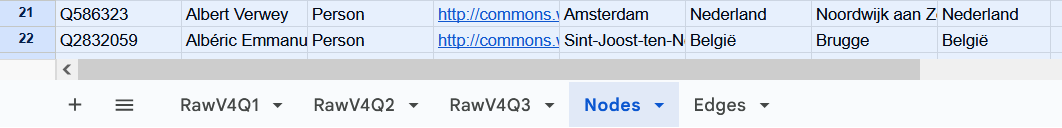

##NODES

In dit document zijn er 3 soorten knopen: de lijst van personen, de lijst van locaties (werk, geboorte, sterfte, wonen), en een lijst van alle landen waartoe die locaties behoren. Daarvoor kunnen we de volgende stappen doorlopen:


1. eerst verzamelen we de personen. Daarvoor kopieëren we uit V4Q1 de kolommen correspondent,correspondentLabel,image,birthPlaceLabel,birthCountryLabel,deathPlaceLabel,deathCountryLabel en plaatsen deze in een nieuw tabblad genaamd 'nodes'. De kolommen omtrent werkplaats en woonplaats zijn moeilijk mee te nemen en worden niet gekopieerd omdat personen meerdere werkplaatsen of woonplaatsen kunnen hebben en dit niet 1-1 te mappen valt op een knoop.

2. Hernoem de eerste 2 kolommen respectievelijk naar 'ID', 'Label'. Zo kan Gephi ze herkennen bij het inladen.

3. Voeg een nieuwe (lege) kolom in na de eerste twee en noem deze 'Type'. Hier kun je voorlopig 'person' ingeven voor alle cellen. De andere kolommen zijn vrij te benoemen. Kies een logische naam. In dit geval krijgen we dan alles samen deze kolommen.

4. Na de personen zullen we ook de plaatsen toevoegen. Dit is iets complexer. De eenvoudigste manier is om eerst de kolommen target en targetlabel uit V3Q2 te nemen en deze onder de personen te kleven in het nodes-tabblad. Het is daarbij belangrijk om de relaties die 'in land' zijn niet mee te kopieëren (want dit zijn landen). Ook de titels van de kolommen niet kopieëren. In de kolom type kan van deze plaatsen 'plaats' ingevuld worden. Daarnaast kan eventueel nog aangevuld worden welke landen bij deze plaatsen horen. Daarvoor kunnen twee nieuwe kolommen aangemaakt worden met de titel 'bijhorendland' en 'bijhorendlandlabel'. Via query V4Q3 kunnen we plaatsen makkelijk linken met landen. In de nieuwe kolom 'bijhorend land' en 'bijhorend land label' kan een Vlookup-functie gebruikt worden om dit automatisch aan te vullen.

In de nieuwe kolom waar de Q-nummer of label moet verschijnen naast de plaats, kan je bijvoorbeeld deze formule gebruiken in de cel in het nodes-bestand:

`= VLOOKUP(B653;RawV4Q3!B:D;3;0)`

B653 is in dit geval de cel waarin de plaatsnaam voorkomt in het nodes-bestand die u wil opzoeken.
RawV4Q3!B:D betekent dat je zoekt in het tabblad van de derde query. (geef dit jouw naam.). In ons geval kiezen we in dit tabblad van de derde queryresultaten kolom B 'placelabel' waarin de naam van de plaats voorkomt.
de waarde '3' geeft aan dat het van deze geselecteerde kolommen de derde index zal weergeven, in ons geval is dat de kolom 'countrylabel'. Tot slot geeft de laatste waarde '0' aan dat het om een exacte procedure gaat en geen benadering. Zo krijgen we voor 'Aalter' het resultaat 'België', enzovoort. Deze formule kan dan naar beneden gesleept worden voor alle plaatsen.

Je gebruikt dezelfde procedure om de Q-nummers te vinden, maar zal dan zoeken op de kolom met Q-nummers in plaats van plaatsnamen.

opmerking: als er bepaalde plaatsen enkel Q-nummers hebben of een label ontbreekt, dan kan je dat altijd handmatig opzoeken via Wikidata en zo aanvullen. In mijn geval waren er enkele van deze resultaten, die op een vreemde manier geen label hadden, of het label was opnieuw de Q-nummer. Deze hebben we handmatig aangepast.

5. Om de landen als knopen toe te voegen, kunnen we simpelweg de kolommen countryItem en CountryitemLabel kopieëren uit v4Q3 en toevoegen in het nodes-bestand onder de personen en plaatsen. In de kolom 'type' kun je ingeven 'land'. Verder voegen we hier niets aan toe.

5. Wikidata URL's verwijderen in de Id-kolom: Gephi kan enkel werken met de Q-nummers, niet met links. Dit kan eenvoudig opgelost worden door de kolom met de links te selecteren en dan in het hoofdmenu (bovenaan) te kiezen voor 'bewerken' en vervolgens 'zoeken en vervangen' te kiezen. Daar kan je instellen om 'http://www.wikidata.org/entity/' te vervangen door '' (leegte). Hierna blijf je enkel met de Q-nummers over. Daarna kopieer je de kolom en plak je ze terug op dezelfde plaats, maar kies 'enkel waarden plakken' in het submenu.

6. opvullen lege cellen: filter instellen, op icoontje in top van kolom klikken en enkel de lege cellen selecteren. Vervolgens in een van deze cellen 'gegevens onbekend' of iets dergelijks ingeven en naar beneden slepen.

7. duplicaten verwijderen: knopen mogen maar een keer voorkomen in de visualisatie. Daarom is het belangrijk alle dubbels te verwijderen. Dat kan door in het hoofdmenu naar in het hoofdmenu te klikken op 'gegevens' - 'gegevens opschonen' - 'duplicaten verwijderen'. Let erop dat je alle kolommen selecteert.

8. Vervolgens kun je de tab de naam 'nodes' geven, indien dit nog niet is gebeurd. Via exporteren of downloaden kun je kiezen om het csv-bestand te downloaden.

opmerking: in retrospect zijn we vergeten de afbeeldingen van de plaatsen en landen, alsook hun wikidata links, wikipedia, enzovoort op te vragen. Dit had nog leuk geweest om verder mee te werken. Hier gaan we momenteel niet verder op in.



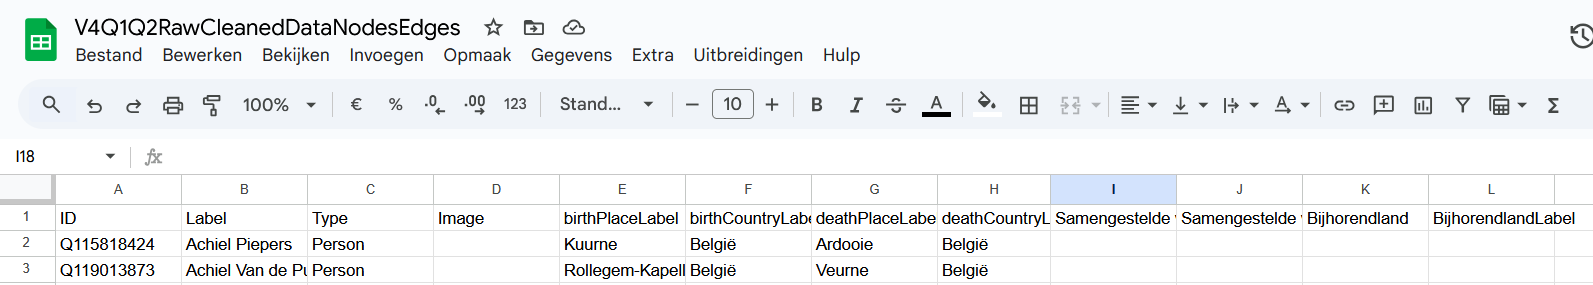

##EDGES

In dit bestand willen we alle verbindingen oplijsten. Concreet gaat het hier om alle relaties op vlak van werkplaats, woonplaats, geboorteplaats en plaats van overlijden.

1. Eerst maken we een nieuw tabblad met de naam 'edges' aan in de spreadsheet

2. kopieer de kolommen 'source','target','relationshipType' uit de 2de query (V4Q2) naar het edges-blad. Je hoeft de titels van de kolommen niet aan te passen.

3. Vervolgens kopieer je de kolommen 'placeItem' en 'countryitem' uit de derde query (V4Q3) naar het edges-blad. Deze plak je onmiddellijk onder de andere relaties van de kolommen 'source' en 'target' in het edges-blad. In de kolom 'relationshipType' plaats je voor al deze relaties 'In Land' in de cellen. Vul daarvoor deze waarde in voor een cel en sleep naar beneden.

4. Rechts van de kolommen 'source' en 'target' kunnen twee nieuwe kolommen ingevoegd worden. Noem deze kolommen  'type' en 'weight' toe. Geef bij 'type' directed (of undirected) in en sleep voor alle rijen dezelfde waarde. In de kolom 'weight' kan de waarde '1' ingevoerd worden. Selecteer opnieuw deze cel en sleep voor alle rijen naar beneden.

5. Wikidata URL's verwijderen in de Id-kolom: Gephi kan enkel werken met de Q-nummers, niet met links. Dit kan eenvoudig opgelost worden door de kolom met de links te selecteren en dan in het hoofdmenu (bovenaan) te kiezen voor 'bewerken' en vervolgens 'zoeken en vervangen' te kiezen. Daar kan je instellen om 'http://www.wikidata.org/entity/' te vervangen door '' (leegte). Hierna blijf je enkel met de Q-nummers over. Daarna kopieer je de kolom en plak je ze terug op dezelfde plaats, maar kies 'enkel waarden plakken' in het submenu.

6. in dit geval kan het zijn dat er duplicaten zijn, doordat de meeste 'in land'-verbanden al zijn opgenomen in V4Q2. we kunnen deze verwijderen door alle kolommen te selecteren en dan naar 'gegevens' te gaan in het hoofdmenu. Daar kan vervolgens geklikt worden op 'gegevens opschonen'- 'duplicaten verwijderen'. Let erop dat je alle kolommen geselecteerd hebt die van belang zijn! We doen ook nog een check in Gephi en passen daar aan indien er nog dubbels overgebleven zijn.

7. Sla het bestand op en exporteer het tabblad als edges.csv




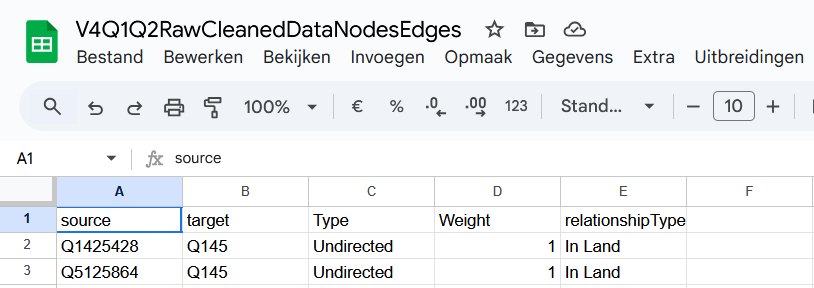

##GEPHI

In Gephi kunnen beide documenten (nodes en edges) opgeladen worden om een netwerkvisualisatie te bekomen. Hieronder wordt toegelicht hoe dat te doen.

Eerst laden we de nodes.csv in. Vervolgens laden we de edges.csv in hetzelfde spreadsheet in Gephi. Open Gephi en start een nieuw project. Vervolgens laden we eerst de node file in. Via 'file' en dan 'import spreadsheet' kunnen de documenten worden ingeladen. Selecteer het bestand en kies bij het menu 'import as' voor 'node table'. Klik een paar keer op 'next' en kies ervoor om de data op het huidige tabblad in te laden. Doe hetzelfde voor de edges-file, maar kies dan voor 'edges table'.

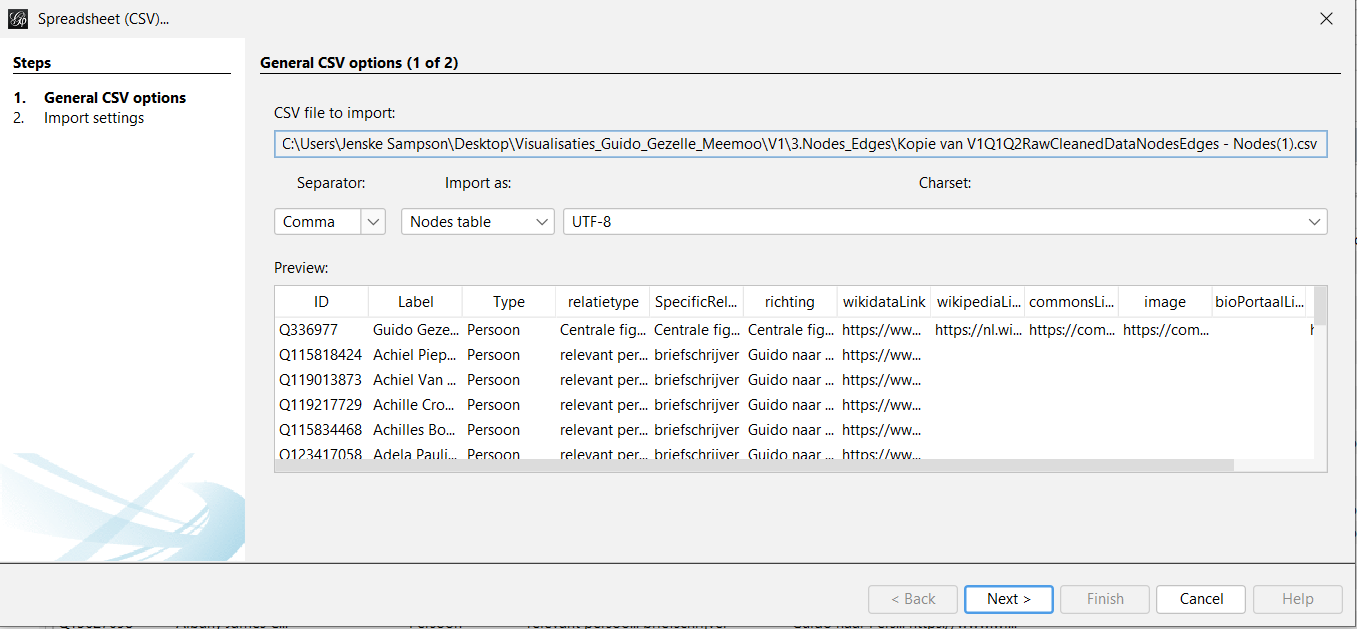

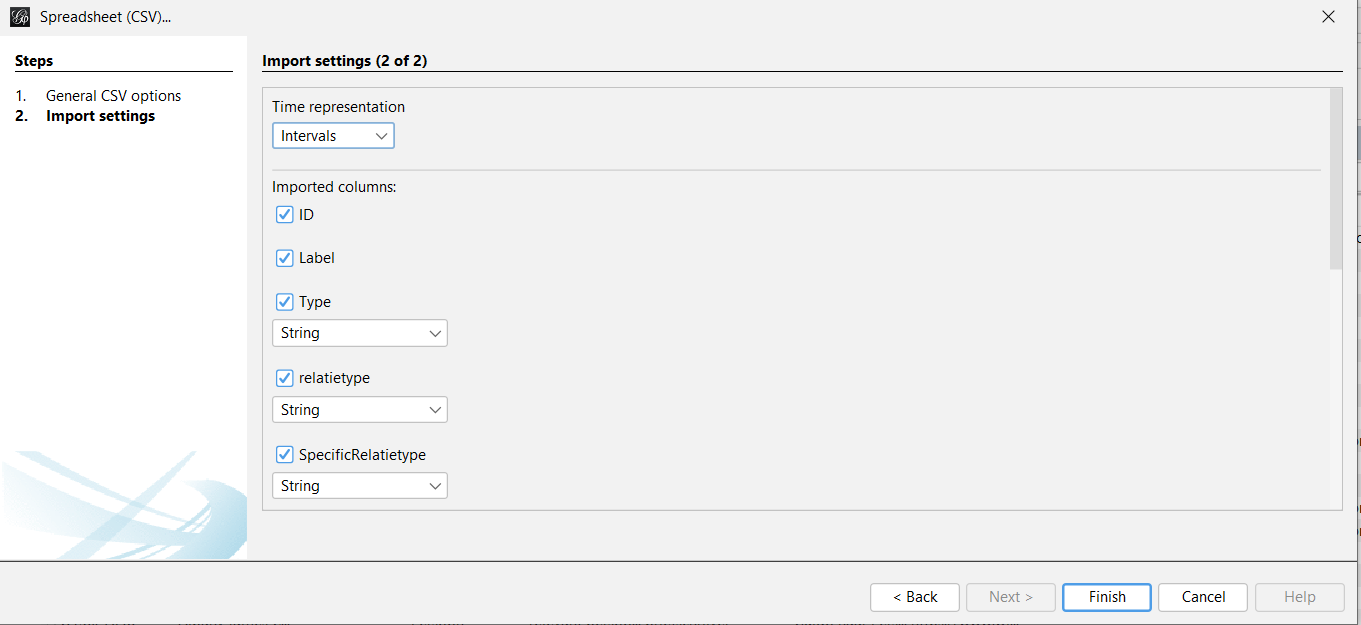


Nu beide bestanden zijn ingeladen, kan overgegaan worden op de layout van de graph. Ga in het hoofdmenu naar 'overview'. Je ziet nu volgende visualisatie:

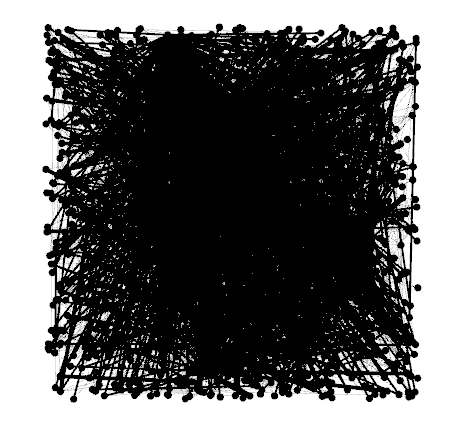

opmerking: Soms krijg je bij het inladen fouten zoals dubbele nodes. In sommige gevallen konden we dit niet onmiddellijk verklaren en/of oplossen. Op zich kun je gewoon verder inladen en dit oplossen in Gephi zelf. Moesten er toch foutjes zijn in de visualisatie (bijvoorbeeld met grote pijlen/edges), dan kan je in ' data laboratory' naar de 'edge'-tab kijken naar het gewicht van de edges. Je kunt in dit geval alles selecteren door te slepen en met een rechterklik kiezen voor 'edit edges'. Links zul je een menu zien waar je de weight variabele kunt aanpassen. Hier kun je de waarde 1 ingeven voor alle edges. Op die manier zijn alle verbindingen even sterk en ziet de visualisatie er 'normaal' uit.

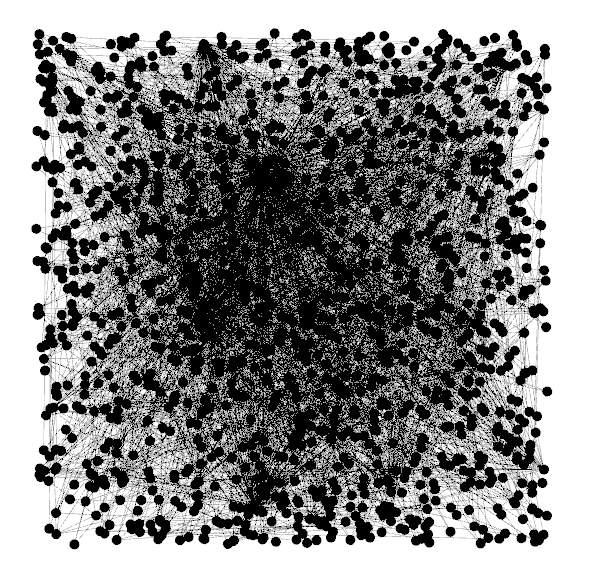

Vervolgens ordenen we de visualisatie. Om tot de gewenste vorm te komen, kun je links bij 'layout' kiezen uit een lijst sorteeralgoritmes.  Hier kiezen we voor ForceAtlas2. Kies dit en pas de 'scaling' en 'gravity aan naar waarde '55' en waarde '75'. Druk vervolgens op 'Run'. Na enkele minuten kun je ook ordenen op 'no overlap'. Je krijgt nu onderstaande vorm:

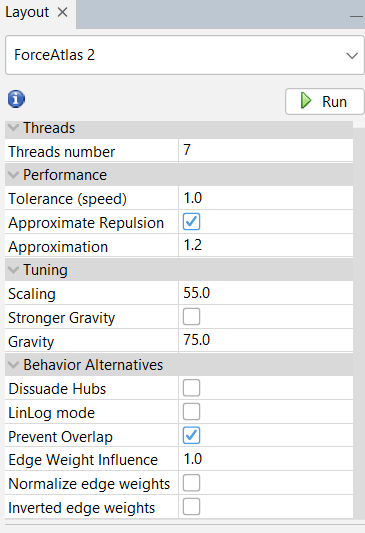

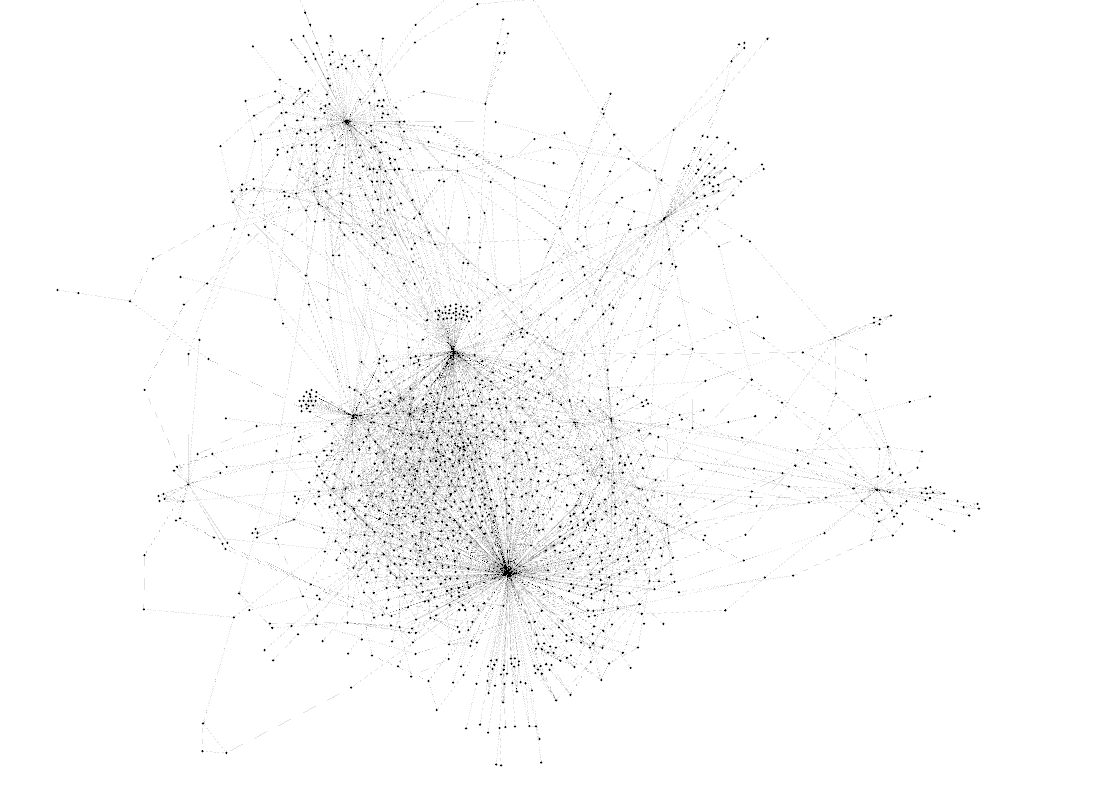

Vervolgens kunnen we ook de grootte en kleur van de knopen en verbindingen aanpassen om de visualisatie intuïtiever te maken. De kleur van de knopen verwijst in dit geval naar het type (persoon, plaats of land). De grootte wordt bepaald door de 'degree';het aantal verbindingen met andere knopen. Beiden kunnen aangepast worden in het 'appearance'-menu aan de linkerkant. Indien dit niet zichtbaar is, kan het in het hoofdmenu (boven) geselecteerd worden onder het tabblad 'windows'.


je kan 'nodes' selecteren. Vervolgens klik je op de icoontjes naast 'node-edge'. Hier kun je de kleur aanpassen op basis van een attribuut, in dit geval 'type'. Om de grootte aan te passen klik je op het andere icoontje. Daarna kun je kiezen voor attribute 'Degree' en een min size van '20' en max size van '150' instellen. Mogelijk moet je daarna het sorteeralgoritme nogmaals laten draaien.

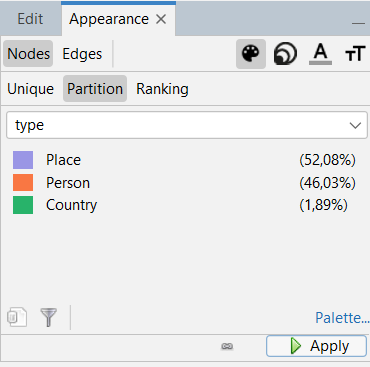

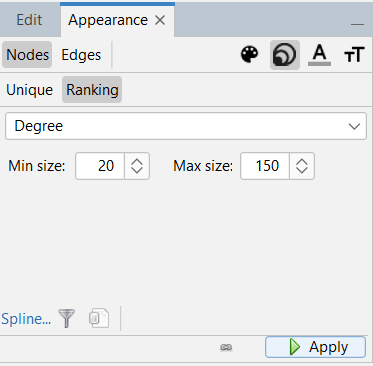

De kleur van de verbindingen wijst op het relatietype, in dit geval werkgever (paars), onderwijsinstelling (oranje) of lid van vereniging (groen). Ook dit kan geselecteerd worden in het 'appearance'-menu, in dit geval onder de 'edges' tab. Daar kies je voor attribuut 'relatiettype' en drukt op 'apply'. Ook de lijndikte van de edges kan aangepast worden. Daarvoor moet in dit geval geschoven met de waarde van het balkje naast het witte 'T' icoontje onder de visualisatie

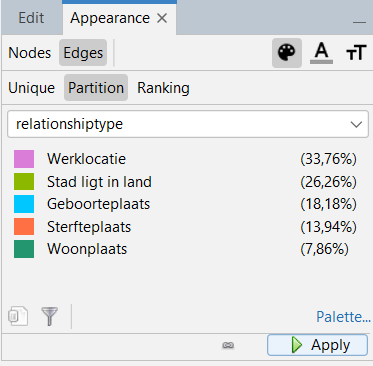

Na deze aanpassingen krijgen we volgende visualisatie te zien in het 'overview'-scherm

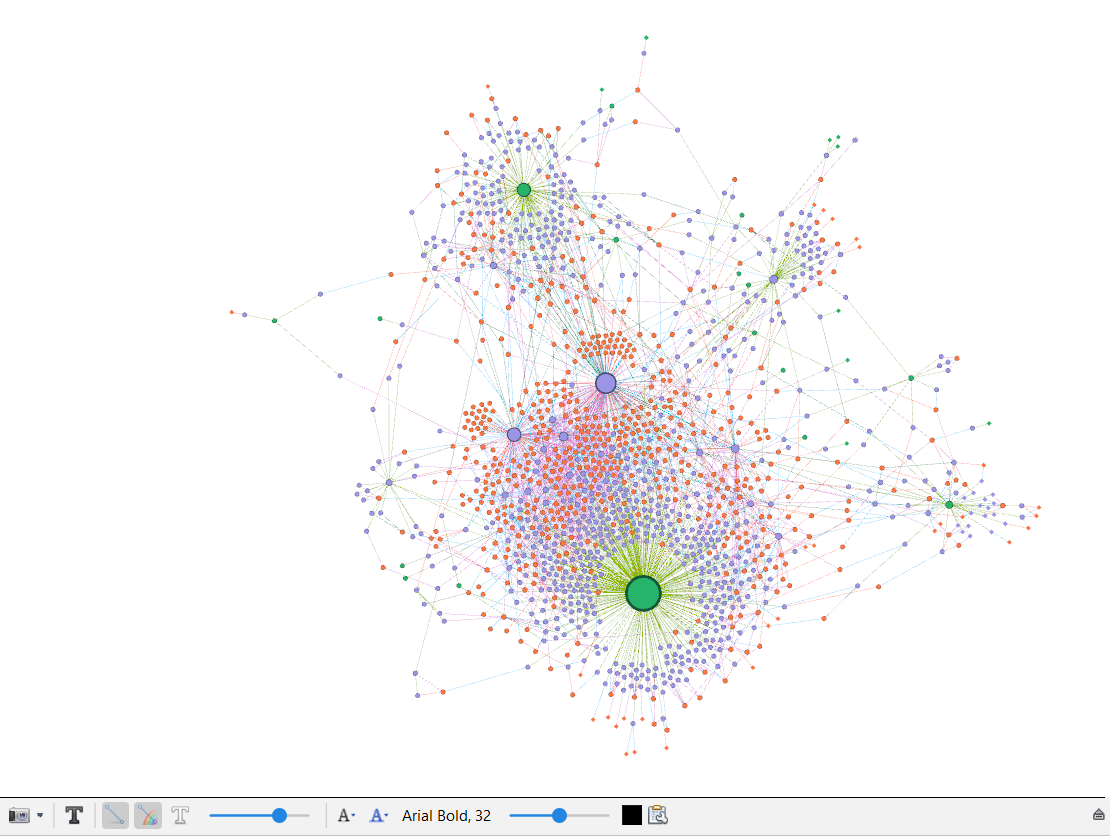

Daarnaast kan het nog interessant zijn de verbindingen dikker te maken en de labels enkel zichtbaar te maken voor de geselecteerde knopen. De verbindingen kunnen dikker gemaakt worden in het preview scherm onder 'edges'- 'thickness'. Hier kan je de waarde verhogen. Een andere manier om de verbindingen en de pijlen dikker te maken is via het 'overview'-scherm. Hier kun je onder de visualisatie enkele tools vinden, bijvoorbeeld een grote witte letter 'T'. Door de balk te verschuiven, worden de lijnen dikker.


Tot slot kan ook het label zichtbaar gemaakt worden wanneer deze geselecteerd wordt. Alle labels op elk moment tonen wordt te onoverzichtelijk. Om dit te doen, drukken we op het symbooltje rechts onderaan ten opzichte van de visualisatie. Er opent dan een extra menu waar onder het tabblad 'labels' gekozen kan worden voor 'highlight selection'. Vervolgens vinken we links het vakje naast 'Node' aan, om de nodes bij selectie zichtbaar te maken (zie foto).

In het hoofdmenu kan naast 'overview' en 'data laboratory' ook gekozen worden voor een 'preview'-menu. Hier kan nog vanalles aangepast worden aan het model. in het bijzonder kun je hier kiezen voor 'curved' in plaats van 'straight' edges. Ook de dikte van de edges kan hier bijvoorbeeld aangepast worden, alsook of labels zichtbaar zijn, lettertypes, enzovoort.

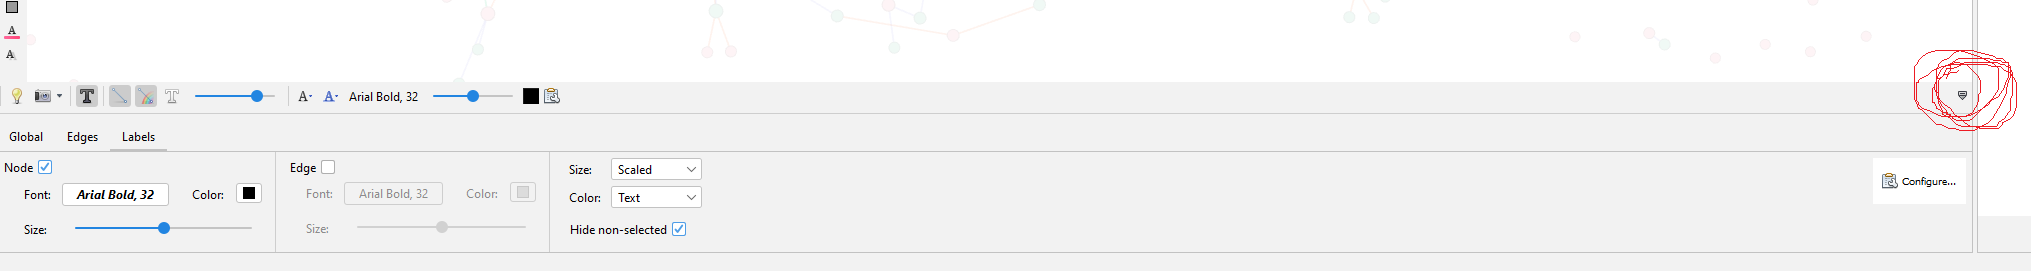

opmerkingen: in het 'preview'-blad van Gephi (naast Overview en Data laboratory) kunnen ook heel erg veel van deze en andere zaken aangepast worden in de visualisatie. Hier hebben we slechts enkele van de belangrijkste functies vanuit het 'overview'-menu voor deze visualisatie toegelicht.

**Aanpassing kleur knopen landen**

Als we naar de visualisatie kijken, zien we dat sommige landen geïndiceerd zijn als plaats. Daardoor krijgen ze een blauwe in plaats van groene kleur qua knoop. Om enkele van deze foutjes op te lossen, kunnen we deze knopen handmatig veranderen naar de correcte kleur, in dit geval '40,179,106'. druk eerst op het cursor-icoontje met een vraagteken en selecteer dan de knoop. Je krijgt dan een venster met properties te zien aan de linkerkant in een nieuw venster. Hier kun je de waarde van 'color' aanpassen.

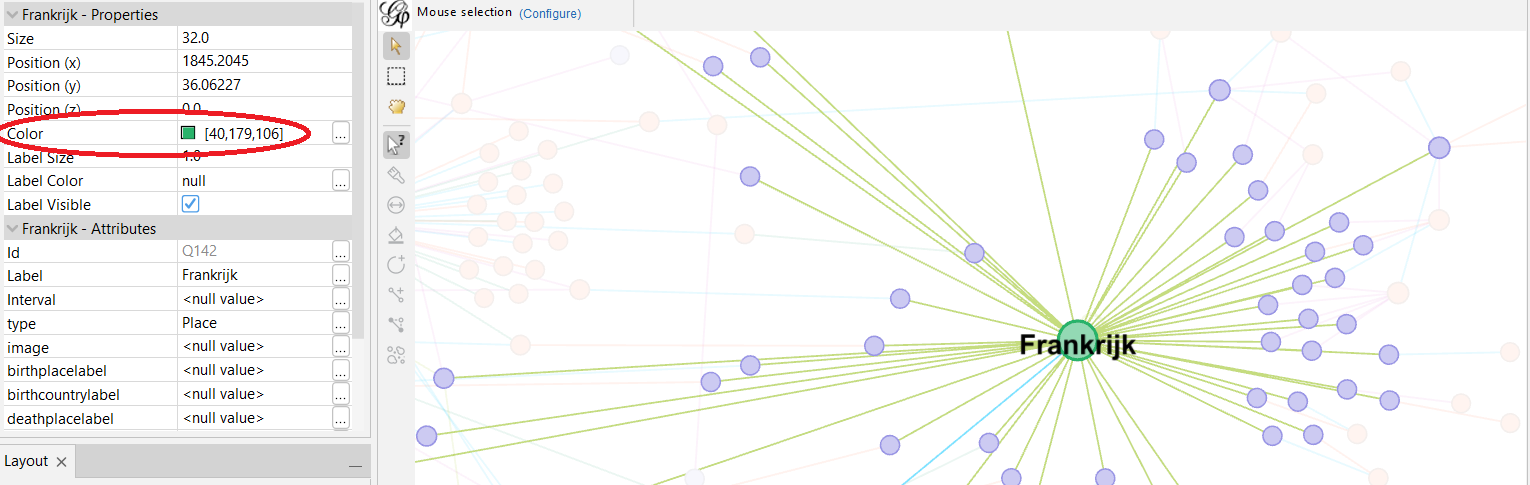

**Importeren nieuw bestand met nodes of edges**

Als je later toch de data van de nodes of edges wil aanpassen in de originele spreadsheets, kun je de aangepaste versies eenvoudig opnieuw downloaden vanuit Excel of Google Spreadsheets en inladen via 'Data Laboratory'-'import spreadsheet' in Gephi. Je kan daarvoor eerst alle nodes of edges selecteren (ctrl+a) in Gephi en dan verwijderen. Vervolgens kun je de nieuwe set selecteren en inladen, zoals je deed na de opstart van Gephi.

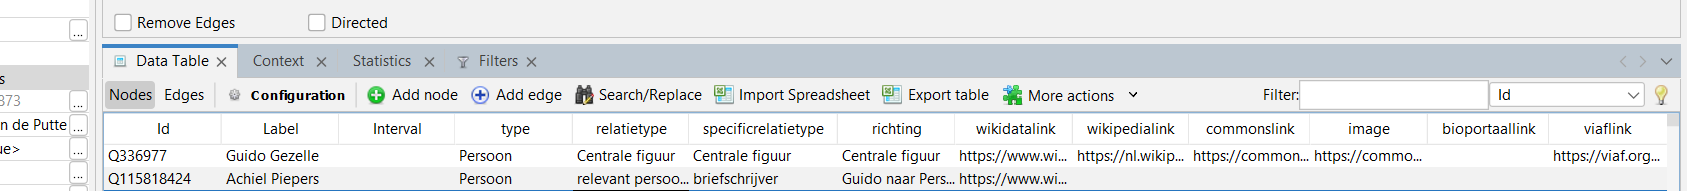

##EXPORTEREN MET SIGMA

Nu enkele aanpassingen zijn gebeurd qua layout via Gephi, zullen we de visualisatie exporteren en klaarmaken om op interactieve manier online te plaatsen. In dit geval zullen we gebruik maken van de plugin Sigma. Deze is geintegreerd in Gephi en kan op eenvoudige wijze geactiveerd en gebruikt worden. Andere plugins kunnen gebruikt worden, of indien je wat kunt programmeren is html en java ook een oplossing. In een van de andere visualisaties (zie andere hoofdstukken) maken we een plugin/interface met behulp van Gemini 3.0.

Hier tonen we hoe je de plugin installeert. Daarna tonen we hoe je aanpassingen maakt voor de instellingen van de export.
Eerst ga je naar tools in het hoofdmenu (bovenaan), daarna klik je op plugin. In de interface zoek je naar Sigma Exporter. Je installeert die en drukt op 'active'. Eens geactiveerd, moet je Gephi herstarten om de plugin te laten werken. Na heropstart kan je je project exporteren.



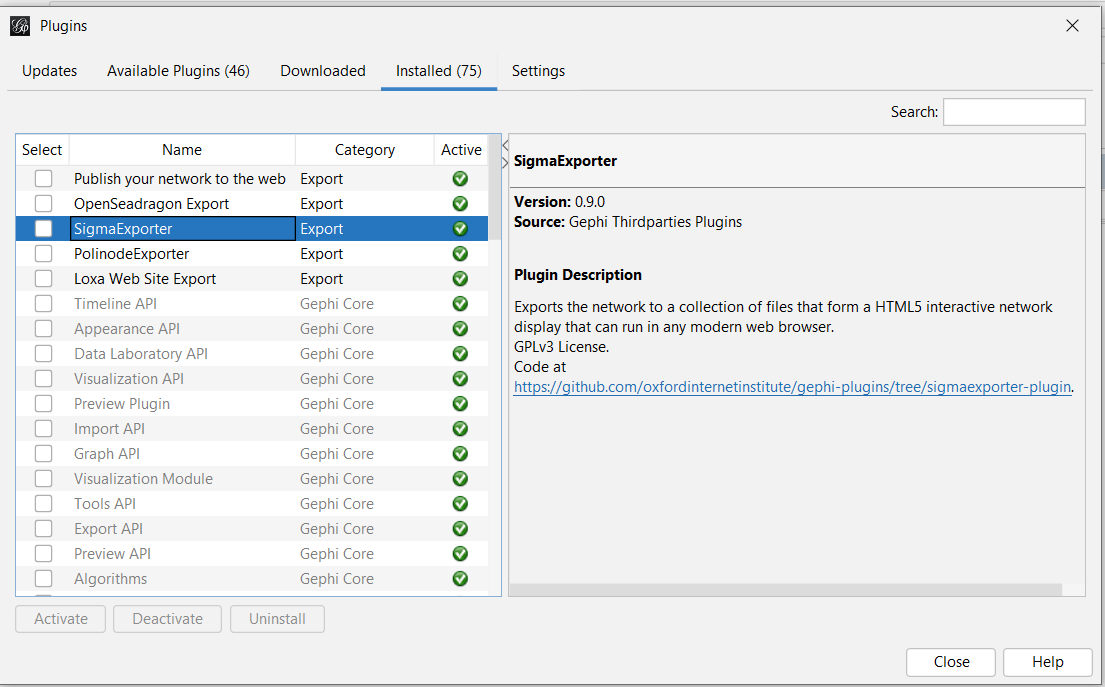

Vervolgens kan er geëxporteerd worden via Sigma. Dit kan door in het hoofdmenu bovenaan naar 'file' te navigeren en dan te kiezen voor 'export' en vervolgens 'sigma.js template'. Je krijgt dan dit menu te zien:

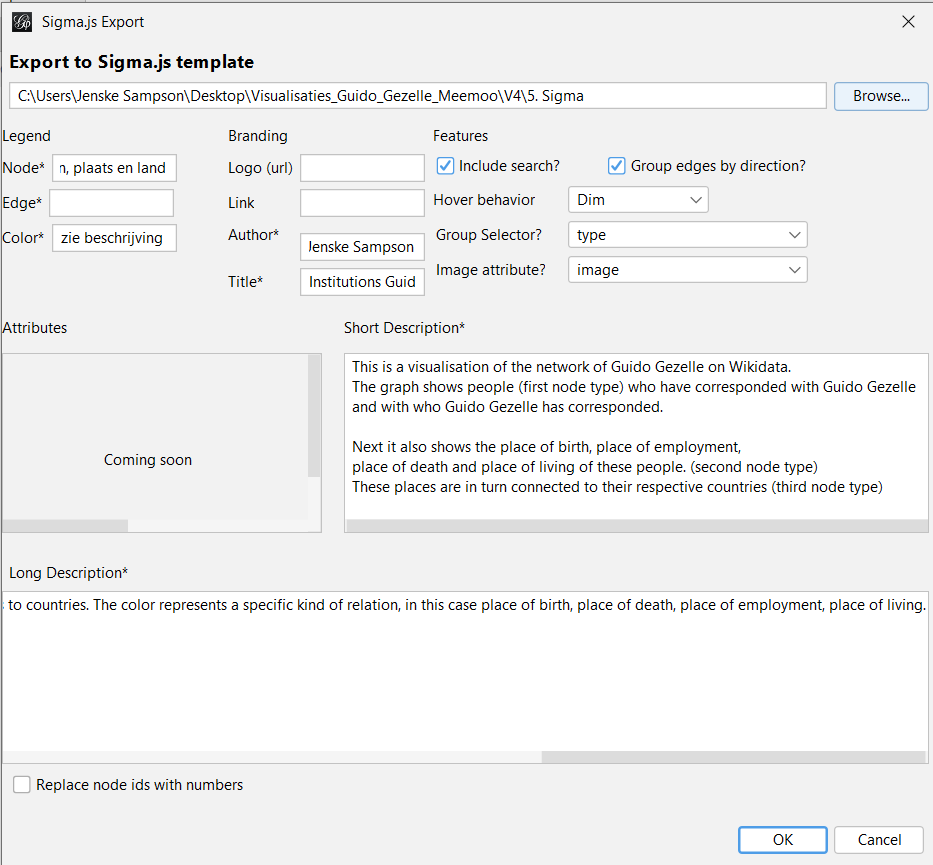

Er kan uitleg geplaatst worden bij de nodes en edges. Hier geven we aan dat node een 'persoon' representeert. In de korte beschrijving kan meer uitleg geplaatst worden. Deze is beperkt door de ruimte die ze onmiddellijk inneemt op het scherm. Een interessante functie die ingesteld kan worden is de 'group selector'. Hier kan een indeling op basis van een attribuut gemaakt worden. In dit geval kiezen we voor het specifieke type van de persoon, bv relevant persoon, vertaler, broer of zus, familielid, enzovoort. Sigma kan ook een foto linken en tonen per knoop. Hiervoor linken we de kolom imagelink aan 'image attribute'. Tot slot kan er ook een uitvoerige uitleg bijgevoegd worden. Deze wordt zichtbaar in een popup-venster, waardoor de lengte veel meer kan zijn en niet in strijd komt met het zichtbare netwerk en de rest van de interface.

Eens we de visualisatie opladen via Github (zie verder), zal dit er ongeveer zo uitzien:

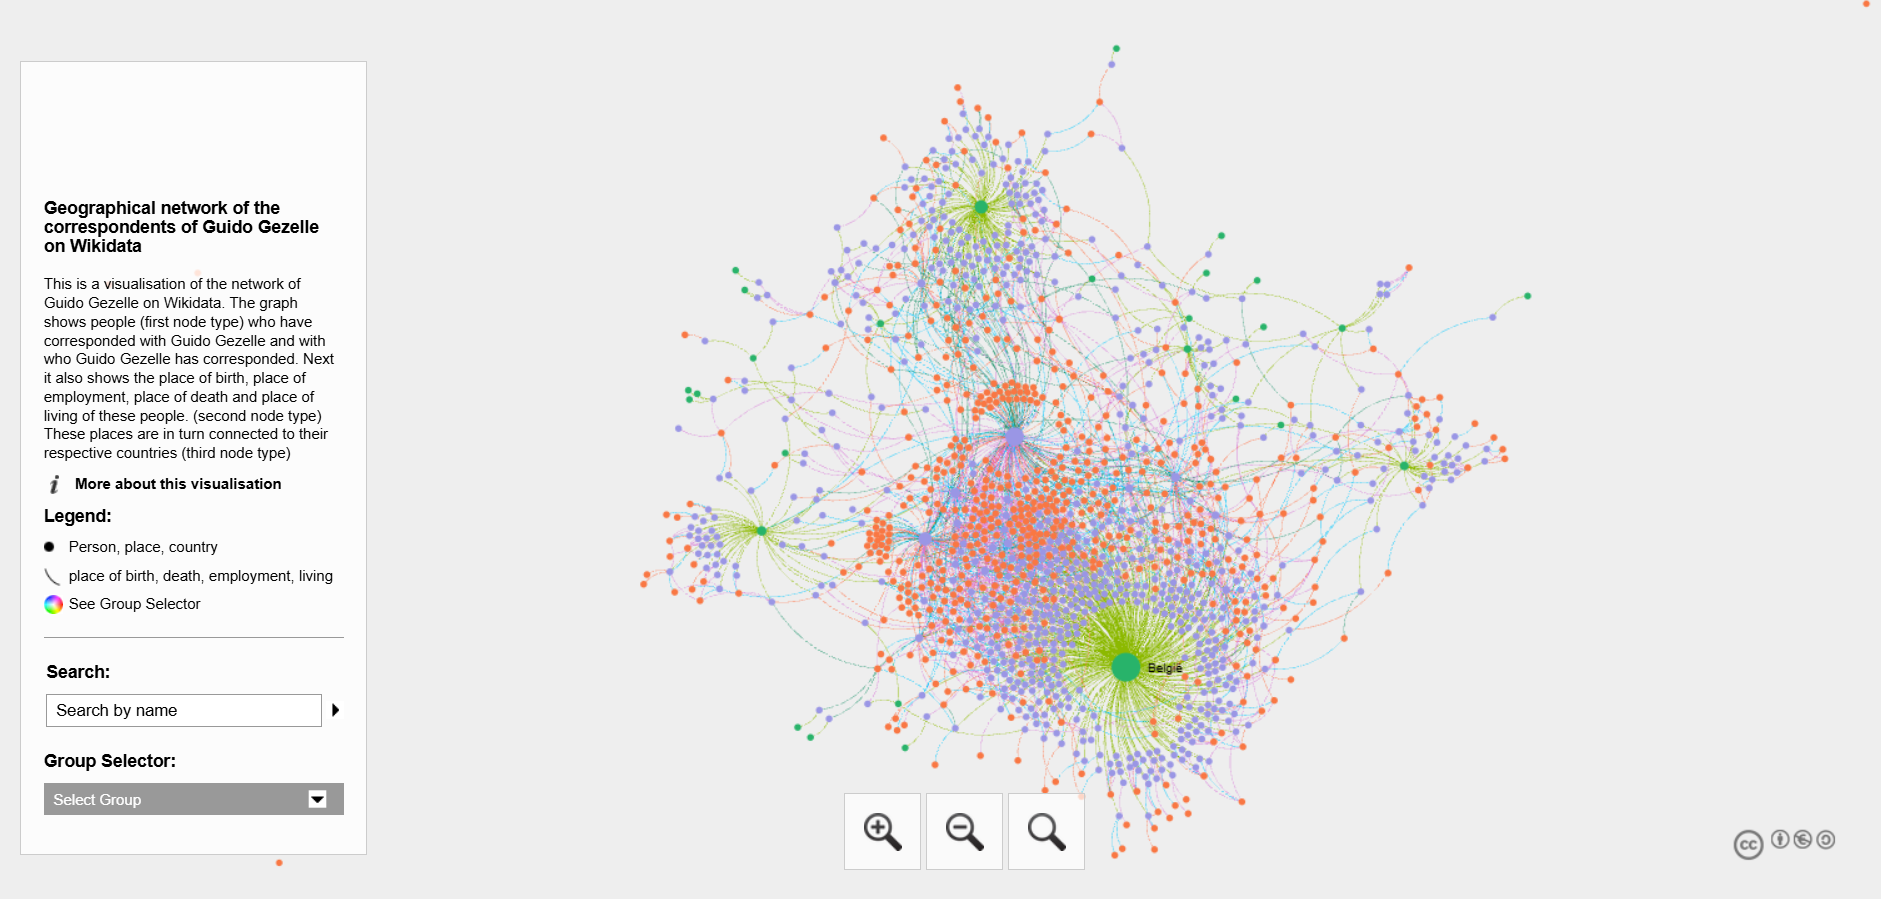

##AANPASSEN SCRIPT

Nu de pagina opgeladen is als interactieve webpagina, kunnen we nog een paar laatste details aanpassen. Dit is mogelijk het meeste technische gedeelte van deze handleiding. De bedoeling is om de code die door Sigma gegenereerd werd om de interface wat om te vormen. Zo wordt informatie beter weergegeven en is interactie eenvoudiger.

Bij deze visualisatie willen we graag de volgende zaken aanpassen na de Sigma-export. Ook hier zullen we de code daarvoor aanpassen van verschillende bestanden. 1)we zullen het paneel aan de rechterkant 'information pane' in plaats van 'information panel'. 2)Daarnaast willen we ook dat velden 'type', 'bijhorend land label' voor plaatsen getoond worden, en voor personen wordt 'geboorteplaats' en 'geboorteland', alsook 'plaats van overlijden' en land van overlijden. ' 3) momenteel is de afbeelding nog wat groot soms in het rechtermenu. Dat willen we kunnen oplossen.4) eventueel willen we ook nog meer informatie laten zien zoals een link naar de afbeelding en een link naar het wikidata item van de knoop. 5) in de group-selector willen we namen kunnen geven aan de groepen, in dit geval persoon of instituut, 6) tot slot willen we de verbindingen opdelen in verbinden op vlak van geboorteplaats, plaats van overlijden, werkplaatsen en woonplaatsen.



Door gebrek aan technische kennis om goed te kunnen programmeren, hebben we ook de hulp van Gemini 2.5 en 3.0 gevraagd. Op die manier zijn we aan de slag gegaan met de bestanden uit de Sigma-export. Een nuttige tip is om elk van deze problemen afzonderlijk en stap voor stap op te lossen door goede prompts op te stellen. Hierbij vervang je bestand na bestand en ga je iedere stap na of de visualisatie nog werkt. Aangezien het ook mogelijk is bestanden door te sturen in Gemini, hebben we de config.json, index.html, data.json en main.js laten analyseren. Door aanpassingen te maken in deze vier bestanden zijn alle problemen hierboven aangepast. Dat kan in Github zelf, door op de bestanden in de repository te klikken en vervolgens te bewerken. Door deze veranderingen te 'committen', voer je de aanpassingen door. Zo heb je een controle van verschillende versies indien er iets misgaat. Je kan ook beslissen om de aanpassingen via Notepad door te voeren en later op Github op te laden.

###**1. Correctie fout in 'information panel'**:

het eerste probleem is simpel op te lossen door in de index.html te zoeken naar 'information pane' en deze simpelweg aan te passen naar 'information panel'. Vervolgens kun je het bestanden opnieuw opladen.

###**2. Tonen attributen in knopen en bepalen volgorde**:

Stap 1: Zoek de functie nodeActive

Zoek in je main.js naar de functie function nodeActive(a).

Stap 2: Vervang de functie

Vervang de gehele nodeActive functie door de onderstaande versie.

We hebben het het gedeelte waar de attributen (f.attributes) worden uitgelezen (ongeveer regel 620 in je originele bestand) herschreven.
JavaScript


```
function nodeActive(a) {
    var groupByDirection = false;
    if (config.informationPanel.groupByEdgeDirection && config.informationPanel.groupByEdgeDirection == true) groupByDirection = true;

    sigInst.neighbors = {};
    sigInst.detail = !0;
    var b = sigInst._core.graph.nodesIndex[a];
    showGroups(!1);
    var outgoing = {}, incoming = {}, mutual = {};

    sigInst.iterEdges(function (b) {
        b.attr.lineWidth = !1;
        b.hidden = !0;

        n = {
            name: b.label,
            colour: b.color
        };

        if (a == b.source) outgoing[b.target] = n;
        else if (a == b.target) incoming[b.source] = n;
        if (a == b.source || a == b.target) sigInst.neighbors[a == b.target ? b.source : b.target] = n;
        b.hidden = !1, b.attr.color = "rgba(0, 0, 0, 1)";
    });

    var f = [];
    sigInst.iterNodes(function (a) {
        a.hidden = !0;
        a.attr.lineWidth = !1;
        a.attr.color = a.color
    });

    if (groupByDirection) {
        for (e in outgoing) {
            if (e in incoming) {
                mutual[e] = outgoing[e];
                delete incoming[e];
                delete outgoing[e];
            }
        }
    }

    var createList = function (c) {
        var f = [];
        var e = [], g;
        for (g in c) {
            var d = sigInst._core.graph.nodesIndex[g];
            d.hidden = !1;
            d.attr.lineWidth = !1;
            d.attr.color = c[g].colour;
            a != g && e.push({
                id: g,
                name: d.label,
                group: (c[g].name) ? c[g].name : "",
                colour: c[g].colour
            })
        }
        e.sort(function (a, b) {
            var c = a.group.toLowerCase(),
                d = b.group.toLowerCase(),
                e = a.name.toLowerCase(),
                f = b.name.toLowerCase();
            return c != d ? c < d ? -1 : c > d ? 1 : 0 : e < f ? -1 : e > f ? 1 : 0
        });
        d = "";
        for (g in e) {
            c = e[g];
            f.push('<li class="membership"><a href="#' + c.name + '" onmouseover="sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex[\'' + c.id + '\'])\" onclick=\"nodeActive(\'' + c.id + '\')" onmouseout="sigInst.refresh()">' + c.name + "</a></li>");
        }
        return f;
    }

    var f = [];

    if (groupByDirection) {
        size = Object.size(mutual);
        f.push("<h2>Mututal (" + size + ")</h2>");
        (size > 0) ? f = f.concat(createList(mutual)) : f.push("No mutual links<br>");
        size = Object.size(incoming);
        f.push("<h2>Incoming (" + size + ")</h2>");
        (size > 0) ? f = f.concat(createList(incoming)) : f.push("No incoming links<br>");
        size = Object.size(outgoing);
        f.push("<h2>Outgoing (" + size + ")</h2>");
        (size > 0) ? f = f.concat(createList(outgoing)) : f.push("No outgoing links<br>");
    } else {
        f = f.concat(createList(sigInst.neighbors));
    }

    b.hidden = !1;
    b.attr.color = b.color;
    b.attr.lineWidth = 6;
    b.attr.strokeStyle = "#000000";
    sigInst.draw(2, 2, 2, 2);

    $GP.info_link.find("ul").html(f.join(""));
    $GP.info_link.find("li").each(function () {
        var a = $(this),
            b = a.attr("rel");
    });

    // ---------------------------------------------------------
    // AANGEPAST GEDEELTE VOOR GUIDO GEZELLE VISUALISATIE
    // ---------------------------------------------------------
    f = b.attr;
    if (f.attributes) {
        e = [];

        // 1. IMAGE (Afbeelding tonen)
        // In jouw data.json heet dit veld 'image'
        if (f.attributes['image']) {
            e.push('<div style="margin-bottom:15px;"><img src="' + f.attributes['image'] + '" style="max-width:100%; border-radius:5px;" alt="' + b.label + '" /></div>');
        }

        // 2. WIKIDATA LINK
        // Omdat de "id" in jouw data.json de Q-code is (bv. Q1981740), bouwen we hiermee de link.
        e.push('<div style="margin-bottom:8px;"><strong>Wikidata:</strong> <a href="https://www.wikidata.org/wiki/' + b.id + '" target="_blank" style="color:#0078ff; text-decoration:none;">Bekijk op Wikidata (' + b.id + ')</a></div>');

        // 3. SPECIFIEKE VELDEN TONEN
        // Hier mappen we de naam uit jouw data.json (links) naar de tekst die je wilt tonen (rechts).
        var fieldMapping = {
            "type": "Type",
            "bijhorendlandlabel": "Bijhorend land",
            "birthplacelabel": "Geboorteplaats",
            "birthcountrylabel": "Geboorteland",
            "deathplacelabel": "Plaats van overlijden",
            "deathcountrylabel": "Land van overlijden"
        };

        for (var key in fieldMapping) {
            // Pak de waarde uit de attributen
            var val = f.attributes[key];

            // Check of het attribuut bestaat én niet leeg is
            if (val && val !== "" && val !== "null") {
                // Voeg toe aan de lijst met de mooie naam uit de mapping
                e.push('<span><strong>' + fieldMapping[key] + ':</strong> ' + val + '</span><br/>');
            }
        }

        $GP.info_name.html("<div><span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        $GP.info_data.html(e.join(""));
    }
    // ---------------------------------------------------------
    // EINDE AANGEPAST GEDEELTE
    // ---------------------------------------------------------

    $GP.info_data.show();
    $GP.info_p.html("Connections:");
    $GP.info.animate({ width: 'show' }, 350);
    $GP.info_donnees.hide();
    $GP.info_donnees.show();
    sigInst.active = a;
    window.location.hash = b.label;
}

```

###**3. Grootte van de afbeelding aanpassen**:

Ook hier werd hulp gevraagd aan Gemini. De grootte van de afbeelding wordt bepaald door de HTML-styling binnen de nodeActive functie in mainadj.js. We kunnen dit aanpassen door een vaste maximale hoogte of breedte in te stellen op de <img> tag. Hier is de aangepaste code die een maximale hoogte van 60 pixels instelt voor de afbeelding, waardoor deze als een thumbnail wordt weergegeven.

Zoek de regel in de sectie waar image_attribute waar is (if (image_attribute)) in mainadj.js:

JavaScript
```
// OUDE CODE (in mainadj.js - binnen if (image_attribute))
$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
```

Nieuwe Code (met vaste afmeting)

Vervang de style attribuutwaarde om een maximale hoogte in te stellen (bijvoorbeeld max-height:60px en max-width:60px om een duidelijke thumbnail te krijgen):

JavaScript:
```
// NIEUWE CODE (vervangende regel in mainadj.js)
$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle; max-height:60px; max-width:60px; margin-right: 10px;\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
```

###**4. Wikidata link (reeds aanwezig) en image link toevoegen:**

U moet het volledige if (f.attributes)-blok binnen de functie nodeActive(a) van uw bestand mainadj.js vervangen.

Code om te Verwijderen (in mainadj.js)

Zoek in de functie nodeActive(a) naar het volledige if (f.attributes) blok en verwijder het. De code ziet er ongeveer zo uit (afhankelijk van eerdere aanpassingen):
JavaScript



```
// Start van de code die u moet vervangen/verwijderen:
if (f.attributes) {
    var image_attribute = false;
    if (config.informationPanel.imageAttribute) {
        image_attribute=config.informationPanel.imageAttribute;
    }
    // ... hier staat de oude logica voor het verwerken van attributen,
    // de naam en het tonen van de afbeelding (mogelijk al deels aangepast)
    // ...
    // De laatste regel binnen deze if-blok is waarschijnlijk:
    $GP.info_data.html(e.join("<br/>"))
}
```
Nieuwe Code om te Plakken

Plak in plaats van het verwijderde blok de volgende code. Dit combineert:
Volgorde: type, beroep, Modularity Class eerst. Thumbnail: max-height:60px; max-width:60px; voor de afbeelding. Links: Wikidata-link (via b.id) en de Afbeelding URL.

JavaScript

```
if (f.attributes) {
  		var image_attribute = false;
  		if (config.informationPanel.imageAttribute) {
  			image_attribute=config.informationPanel.imageAttribute;
  		}

        var e = []; // Array voor de attribute display HTML-fragmenten
        var addedAttributes = {}; // Houd bij welke attributen al zijn toegevoegd
        
        // 1. Definieer de gewenste volgorde
        var priorityOrder = ['type', 'beroep', 'Modularity Class'];
        
        // 2. Voeg de geprioriteerde attributen toe in de gedefinieerde volgorde
        for (var i = 0; i < priorityOrder.length; i++) {
            var attrKey = priorityOrder[i];
            
            // Controleer of het attribuut bestaat in de data en niet het afbeelding-attribuut is
            if (f.attributes[attrKey] !== undefined && attrKey !== image_attribute) {
                var d = f.attributes[attrKey];
                
                // Maak de HTML string
                var h = '<span><strong>' + attrKey + ':</strong> ' + d + '</span>';
                
                e.push(h);
                addedAttributes[attrKey] = true;
            }
        }
        
        // 3. Voeg de overige attributen toe
        for (var attr in f.attributes) {
            var d = f.attributes[attr];
            
            if (!addedAttributes[attr] && attr !== image_attribute) {
                var h = '<span><strong>' + attr + ':</strong> ' + d + '</span>';
                e.push(h);
            }
        }

        // --- NIEUWE LOGICA VOOR LINKS ---
        
        // 4. Voeg de Wikidata link toe (gebruikt de node ID als Q-ID)
        var qid = b.id;
        // We gaan ervan uit dat de node ID (b.id) de Q-ID is, en de link is naar de hoofdnaamruimte
        if (qid && qid.match(/^Q[0-9]+$/i)) {
            var wikidata_url = 'https://www.wikidata.org/wiki/' + qid;
            var wikidata_html = '<span><strong>Wikidata:</strong> <a href="' + wikidata_url + '" target="_blank">Bekijk item (' + qid + ')</a></span>';
            e.push(wikidata_html);
        }
        
        // 5. Voeg de Afbeelding URL link toe
        if (image_attribute && f.attributes[image_attribute]) {
            var image_url = f.attributes[image_attribute];
            var image_link_html = '<span><strong>Afbeelding URL:</strong> <a href="' + image_url + '" target="_blank">Directe link</a></span>';
            e.push(image_link_html);
        }

        // --- EINDE NIEUWE LOGICA ---

        // De thumbnail-weergave (reeds aangepast voor max-height/width)
        if (image_attribute) {
        	$GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle; max-height:60px; max-width:60px; margin-right: 10px;\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        } else {
        	$GP.info_name.html("<div><span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        }
        
        // Geef alle attributen en links weer, gescheiden door <br/>
        $GP.info_data.html(e.join("<br/>"))
    }
```

###**5. Groepenselector labels corrigeren**:

Om de labels in de "Group Selector" (het menuutje waar je groepen aan en uit kunt klikken) te veranderen van "Group 1", "Group 2" naar leesbare namen zoals "Personen", "Plaatsen" en "Landen", moeten we de functie configSigmaElements aanpassen in je main.js.

De code groepeert nu op kleur. De slimste manier om dit op te lossen, is door de code te laten kijken naar het eerste puntje (node) in die kleurgroep, daarvan het "type" op te vragen, en dat als label te gebruiken.

Hier is het stappenplan.
Stap 1: Zoek de functie

Open main.js en zoek naar de functie: function configSigmaElements(config).
Stap 2: Zoek het specifieke stukje code

Binnen die functie (ongeveer rond regel 185 in je originele bestand) zie je een stukje code dat begint met var a = [], b, x=1;. Dit is de 'loop' die de regels in het menu aanmaakt.

Het ziet er oorspronkelijk ongeveer zo uit:
JavaScript

// OUDE CODE (NIET KOPIEREN)
var a = [],
    b,x=1;
    for (b in sigInst.clusters) a.push('<div style="line-height:12px"><a href="#' + b + '"><div style="width:40px;height:12px;border:1px solid #fff;background:' + b + ';display:inline-block"></div> Group ' + (x++) + ' (' + sigInst.clusters[b].length + ' members)</a></div>');

Stap 3: Vervang dat stukje code

Verwijder de regels die ik hierboven bij "OUDE CODE" liet zien en vervang ze door deze slimmere versie. Deze versie kijkt in de data welk type bij de kleur hoort en vertaalt dit naar het Nederlands:
JavaScript

   // ... (start van configSigmaElements functie)
    $GP.bg = $(sigInst._core.domElements.bg);
    $GP.bg2 = $(sigInst._core.domElements.bg2);
    // OPGELOST: Group Selector code
    var a = [], b;
    
    // We definiëren hier een vertaling voor je datatypen
    var typeTranslations = {
        "Person": "Personen",
        "Place": "Plaatsen",
        "Country": "Landen"
    };

    for (b in sigInst.clusters) {
        // b is de kleurcode (bijv. rgb(249,119,67))
        // We pakken de eerste node uit deze kleurgroep om te kijken wat voor type het is
        var clusterNodes = sigInst.clusters[b];
        var firstNodeId = clusterNodes[0];
        var firstNode = sigInst._core.graph.nodesIndex[firstNodeId];
        
        var groupLabel = "Onbekend"; // Standaard label

        // Probeer het type op te halen uit de data
        // Omdat je nodes een 'type' attribuut hebben (Person, Place, Country)
        if (firstNode && firstNode.attr && firstNode.attr.attributes && firstNode.attr.attributes.type) {
            var rawType = firstNode.attr.attributes.type;
            // Kijk of we een Nederlandse vertaling hebben
            if (typeTranslations[rawType]) {
                groupLabel = typeTranslations[rawType];
            } else {
                groupLabel = rawType;
            }
        }

        // Maak de HTML voor de selector. De href MOET alleen de kleurcode zijn.
        a.push('<div style="line-height:12px; margin-bottom:5px;"><a href="#' + b + '" style="text-decoration:none; color:#333;">' +
               '<div style="width:12px; height:12px; margin-right:5px; border:1px solid #999; background:' + b + '; display:inline-block; vertical-align:middle;"></div>' +
               '<span style="vertical-align:middle;">' + groupLabel + ' (' + clusterNodes.length + ' leden)</span></a></div>');
    }
    //a.sort();
    $GP.cluster.content(a.join(""));
    // ... (rest van configSigmaElements functie)

Stap 4 vervang deze code in de nodeActive:

Vervang één specifieke regel in de nodeActive functie door de volgende:

Oude, buggy regel:
JavaScript

       $GP.info_name.html("<div><img src=" + f.attributes[image_attribute] + " style=\"vertical-align:middle; max-height:60px; max-width:60px; margin-right: 10px;\" /> <span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");

Nieuwe, werkende regel:
JavaScript

        // Zet de naam van de node bovenaan (zonder de extra code die de bug veroorzaakte)
        $GP.info_name.html("<div><span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");


###**6. Verbindingen opdelen op vlak van werk, woon, geboorteplaats en plaats van overlijden**:

Wat goed dat alles nu werkt! Je doel om de verbindingen (Edges) in het infopaneel te groeperen op basis van het type relatie is een uitstekende stap om de netwerkdata inzichtelijker te maken.

De logica die je uit de andere visualisatie hebt overgenomen, is al grotendeels correct geïmplementeerd in de nodeActive functie. We moeten alleen de logica aanpassen aan de specifieke relatietypes die in jouw dataset voorkomen, namelijk: geboorteplaats, plaats van overlijden, werkplaatsen en woonplaatsen.

In je data.json is de naam van het attribuut voor het relatietype waarschijnlijk relationshiptype of iets dergelijks. Op basis van de logica in je code hierboven, lijkt het erop dat de relatievelden in jouw dataset Geboorteplaats, Sterfteplaats, Werklocatie en Woonplaats zijn.

Hieronder vind je de complete, geoptimaliseerde nodeActive functie. Je hoeft alleen deze functie in je main.js te vervangen.
Oplossing: Groepering van Verbindingen in nodeActive

Vervang de volledige function nodeActive(a) in je main.js door de onderstaande, gecorrigeerde versie:
JavaScript

function nodeActive(a) {
    
    // Herstel basisfunctionaliteit
    sigInst.neighbors = {};
    sigInst.detail = !0;
    var b = sigInst._core.graph.nodesIndex[a];
    showGroups(!1);
    
    // --- CATEGORISATIE VAN VERBINDINGEN ---
    // Objecten om de buren per categorie te bewaren, inclusief de nieuwe "Ligt in Land"
    var relatieGeboorte = {};
    var relatieSterfte = {};
    var relatieWerk = {};
    var relatieWoon = {};
    var relatieLand = {}; // NIEUW: Voor "ligt in land" verbindingen
    
    // 1. Itereer over alle randen om de buren te categoriseren en het netwerk te markeren
    sigInst.iterEdges(function (c) {
        c.attr.lineWidth = !1;
        c.hidden = !0;
        
        var neighborID = (a == c.target) ? c.source : c.target;
        
        // Haal het relatietype op uit de attributen van de rand
        var relatieType = c.attr.attributes && c.attr.attributes.relationshiptype;
        var relatieTypeLower = relatieType ? relatieType.toLowerCase() : '';

        // Data die nodig is voor createList (edge label en edge kleur)
        var n = {
            name: c.label,
            colour: c.color
        };
        
        if (a == c.source || a == c.target) {
            // Maak de rand zichtbaar
            c.hidden = !1, c.attr.color = "rgba(0, 0, 0, 1)";

            // Categorie bepalen en de buur toevoegen. Let op de controle op zowel NL als EN.
            if (relatieTypeLower == "geboorteplaats" || relatieTypeLower == "place of birth") {
                relatieGeboorte[neighborID] = n;
            } else if (relatieTypeLower == "sterfteplaats" || relatieTypeLower == "place of death") {
                relatieSterfte[neighborID] = n;
            } else if (relatieTypeLower == "werklocatie" || relatieTypeLower == "place of employment") {
                relatieWerk[neighborID] = n;
            } else if (relatieTypeLower == "woonplaats" || relatieTypeLower == "place of living") {
                relatieWoon[neighborID] = n;
            } else if (relatieTypeLower == "stad ligt in land" || relatieTypeLower == "located in country") {
                // De "Stad ligt in land" relatie scheiden
                relatieLand[neighborID] = n;
            }
        }
    });
    
    // 2. Verberg alle nodes
    sigInst.iterNodes(function (a) {
        a.hidden = !0;
        a.attr.lineWidth = !1;
        a.attr.color = a.color
    });
    
    // 3. De createList functie (lokale definitie behouden)
    var createList=function(c) {
        var f_html = [];
        var e = [],
            g;
        for (g in c) {
            var d = sigInst._core.graph.nodesIndex[g];
            d.hidden = !1; // Maak de buur-nodes zichtbaar
            d.attr.lineWidth = !1;
            d.attr.color = c[g].colour;
            a != g && e.push({
                id: g,
                name: d.label,
                group: (c[g].name)? c[g].name:"",
                colour: c[g].colour
            })
        }
        e.sort(function (a, b) {
            var c = a.group.toLowerCase(),
                d = b.group.toLowerCase(),
                e = a.name.toLowerCase(),
                f = b.name.toLowerCase();
            return c != d ? c < d ? -1 : c > d ? 1 : 0 : e < f ? -1 : e > f ? 1 : 0
        });
        for (g in e) {
            c = e[g];
            f_html.push('<li class="membership"><a href="#' + c.name + '" onmouseover="sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex[\'' + c.id + '\'])\" onclick=\"nodeActive(\'' + c.id + '\')" onmouseout="sigInst.refresh()">' + c.name + "</a></li>");
        }
        return f_html;
    }
    
    // 4. Genereer de HTML voor het verbindingspaneel met de groeperingen
    var f_list = [];
    
    // Ivm Geboorteplaats
    var sizeGeboorte = Object.size(relatieGeboorte);
    f_list.push("<h2>Geboorteplaats (" + sizeGeboorte + ")</h2>");
    if (sizeGeboorte > 0) {
        f_list = f_list.concat(createList(relatieGeboorte));
    } else {
        f_list.push("<li class=\"no-membership\">Geen verbindingen ivm geboorteplaats.</li>");
    }
    
    // Ivm Sterfteplaats
    var sizeSterfte = Object.size(relatieSterfte);
    f_list.push("<h2>Plaats van overlijden (" + sizeSterfte + ")</h2>");
    if (sizeSterfte > 0) {
        f_list = f_list.concat(createList(relatieSterfte));
    } else {
        f_list.push("<li class=\"no-membership\">Geen verbindingen ivm plaats van overlijden.</li>");
    }
    
    // Ivm Werklocatie
    var sizeWerk = Object.size(relatieWerk);
    f_list.push("<h2>Werkplaatsen (" + sizeWerk + ")</h2>");
    if (sizeWerk > 0) {
        f_list = f_list.concat(createList(relatieWerk));
    } else {
        f_list.push("<li class=\"no-membership\">Geen verbindingen ivm werkplaatsen.</li>");
    }
    
    // Ivm Woonplaats
    var sizeWoon = Object.size(relatieWoon);
    f_list.push("<h2>Woonplaatsen (" + sizeWoon + ")</h2>");
    if (sizeWoon > 0) {
        f_list = f_list.concat(createList(relatieWoon));
    } else {
        f_list.push("<li class=\"no-membership\">Geen verbindingen ivm woonplaatsen.</li>");
    }

    // NIEUW: Ivm Ligt in Land
    var sizeLand = Object.size(relatieLand);
    f_list.push("<h2>Ligt in Land (" + sizeLand + ")</h2>");
    if (sizeLand > 0) {
        f_list = f_list.concat(createList(relatieLand));
    } else {
        f_list.push("<li class=\"no-membership\">Geen verbindingen ivm Land.</li>");
    }

    // 5. Markeer de actieve node en teken de grafiek
    b.hidden = !1;
    b.attr.color = b.color;
    b.attr.lineWidth = 6;
    b.attr.strokeStyle = "#000000";
    sigInst.draw(2, 2, 2, 2);
    
    // Plaats de nieuwe gegroepeerde lijst in het paneel
    $GP.info_link.find("ul").html(f_list.join(""));
    
    // 6. Attribuut Weergave Logica (onveranderd)
    var f_attributes = b.attr;
    var e = [];
    
    if (f_attributes.attributes) {
        var image_attribute = config.informationPanel.imageAttribute || false;
        
        // --- DATA ATTRIBUTEN ---
        // 1. IMAGE (Afbeelding tonen)
        if (f_attributes.attributes['image']) {
            e.push('<div style="margin-bottom:15px;"><img src="' + f_attributes.attributes['image'] + '" style="max-width:100%; border-radius:5px;" alt="' + b.label + '" /></div>');
        }

        // 2. WIKIDATA LINK
        e.push('<div style="margin-bottom:8px;"><strong>Wikidata:</strong> <a href="https://www.wikidata.org/wiki/' + b.id + '" target="_blank" style="color:#0078ff; text-decoration:none;">Bekijk op Wikidata (' + b.id + ')</a></div>');

        // 3. SPECIFIEKE VELDEN TONEN
        var fieldMapping = {
            "type": "Type",
            "bijhorendlandlabel": "Bijhorend land",
            "birthplacelabel": "Geboorteplaats",
            "birthcountrylabel": "Geboorteland",
            "deathplacelabel": "Plaats van overlijden",
            "deathcountrylabel": "Land van overlijden"
        };

        for (var key in fieldMapping) {
            var val = f_attributes.attributes[key];
            if (val && val !== "" && val !== "null") {
                e.push('<span><strong>' + fieldMapping[key] + ':</strong> ' + val + '</span><br/>');
            }
        }
        
        // --- TITEL WEERGAVE ---
        $GP.info_name.html("<div><span onmouseover=\"sigInst._core.plotter.drawHoverNode(sigInst._core.graph.nodesIndex['" + b.id + '\'])" onmouseout="sigInst.refresh()">' + b.label + "</span></div>");
        
        $GP.info_data.html(e.join(""));
    }
    
    // 7. Het informatiepaneel tonen
    $GP.info_data.show();
    $GP.info_p.html("Connections:");
    $GP.info.animate({width:'show'},350);
    $GP.info_donnees.hide();
    $GP.info_donnees.show();
    sigInst.active = a;
    window.location.hash = b.label;
}

Opmerking:
Op elk moment kan de dataset aangepast worden door op github naar het bestand 'data.json' te gaan en dit te vervangen door een nieuwe export vanuit Gephi (of elders).
De titel, korte en uitgebreide beschrijving, enzovoort kunnen eenvoudig aangepast worden in het config.json of index.html via Github of een andere editor.
Ook de algemene werking van de interface kan aangepast worden via het main.js- bestand. Ook dit kan vervangen worden of aangevuld worden waar nodig met nieuwe code.

In deze handleiding werd een visualisatie gemaakt op basis van beschikbare data omtrent Guido Gezelle.
Eerst werden enkele queries ontworpen. Daarna werden deze via Spreadsheets omgezet naar een knopenbestand en een verbindingenbestand. Daarna werd getoond hoe deze bestanden opgeladen worden in Gephi en er een visualisatie van gemaakt wordt. Er werd stilgestaa6n bij de layout, alsook bij de export via Sigma. In een laatste fase werd de interactieve visualisatie online beschikbaar gemaakt als Github-webpagina. Met behulp van generatieve AI, in dit geval Gemini, werd de code aangepast om wat meer functionaliteit toe te voegen.

## UPLOAD GITHUB

Vervolgens wilden we deze visualisatie interactief kunnen aanbieden op een website. Via github kunnen we deze documenten opladen en omzetten in een webpagina. Op zich is dit niet erg moeilijk eens men een account heeft op Github. Eerst en vooral moet er een repository gemaakt worden. Dit repository kan vervolgens omgezet worden tot een Github-page. Via de link naar de page krijg je de visualisatie te zien.

**Repository**

Eerst en vooral maak je dus een nieuw repository aan op Github. Geef het een toepasselijke naam, bv 'VisualisatieGezelle1'. Vervolgens wordt de map met bestanden die werd klaargemaakt door Sigma hierin opgeladen.
Opmerking: het is belangrijk de inhoud van de map 'network' te kopiëren. De map 'network' zelf wordt niet mee gekopieerd. in dit geval zijn dit ongeveer 33 bestanden.

Klik op 'add files/upload new files'. Dit lukt mogelijk enkel in Chrome. Sommige browsers nemen niet alle bestanden over. Eens het opladen klaar is, kan je op 'commit' drukken. De bestanden zitten nu in het repository

**Github page**

nu zullen we van het repository een webpagina maken. Daarvoor klikken we op het 'repository' en gaan vervolgens naar de 'settings'. Daar kiezen we voor 'pages'. Onder 'build and deployment' selecteer je 'main' als branch en in het vak ernaast voor 'root'. Klik vervolgens op 'save'. Wacht enkele minuten en herlaad de pagina. Je zult nu een link te zien krijgen waarop de webpagina te bekijken is:

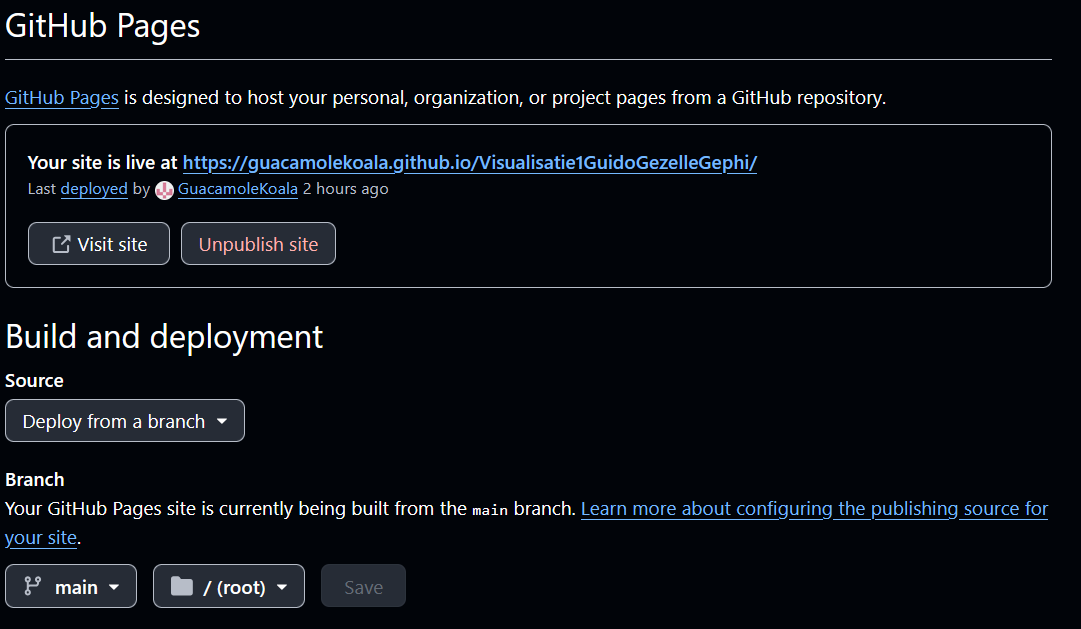

**Version control**

Je kan de code die opgeladen is, ook makkelijk aanpassen via het platform via Github. Op die manier kan je ook een controle/geschiedenis opbouwen aan veranderingen in je code. Op die manier kan je ook terugkeren naar een eerder moment, moest er iets fout lopen.

Opmerking:
Op elk moment kan de dataset aangepast worden door op github naar het bestand 'data.json' te gaan en dit te vervangen door een nieuwe export vanuit Gephi (of elders).
De titel, korte en uitgebreide beschrijving, enzovoort kunnen eenvoudig aangepast worden in het config.json of index.html via Github of een andere editor.
Ook de algemene werking van de interface kan aangepast worden via het main.js- bestand. Ook dit kan vervangen worden of aangevuld worden waar nodig met nieuwe code.

**Code aanpassen op Github:**



Je kan code van de bestanden gemakkelijk aanpassen via Github. Ga daarvoor naar de repository die je eerder hebt gemaakt en bekijk de bestanden door erop te klikken.

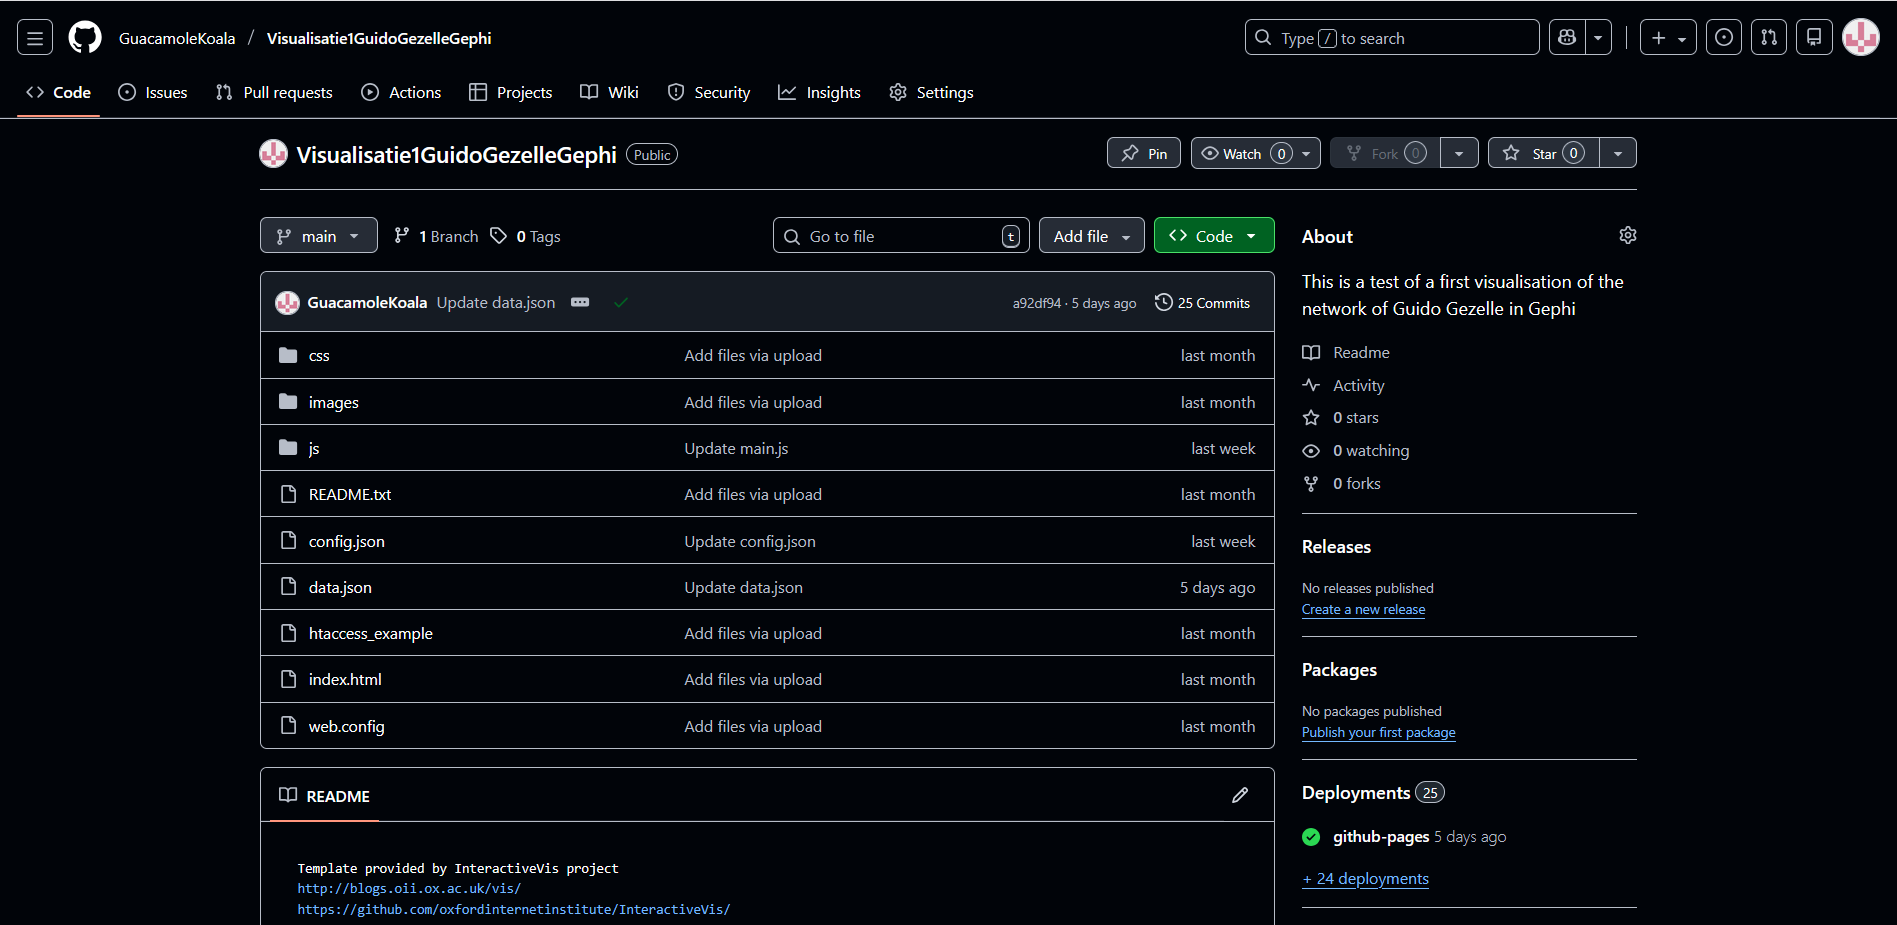

Als je rechts op het potlood-icoontje klikt, kun je de code direct aanpassen.

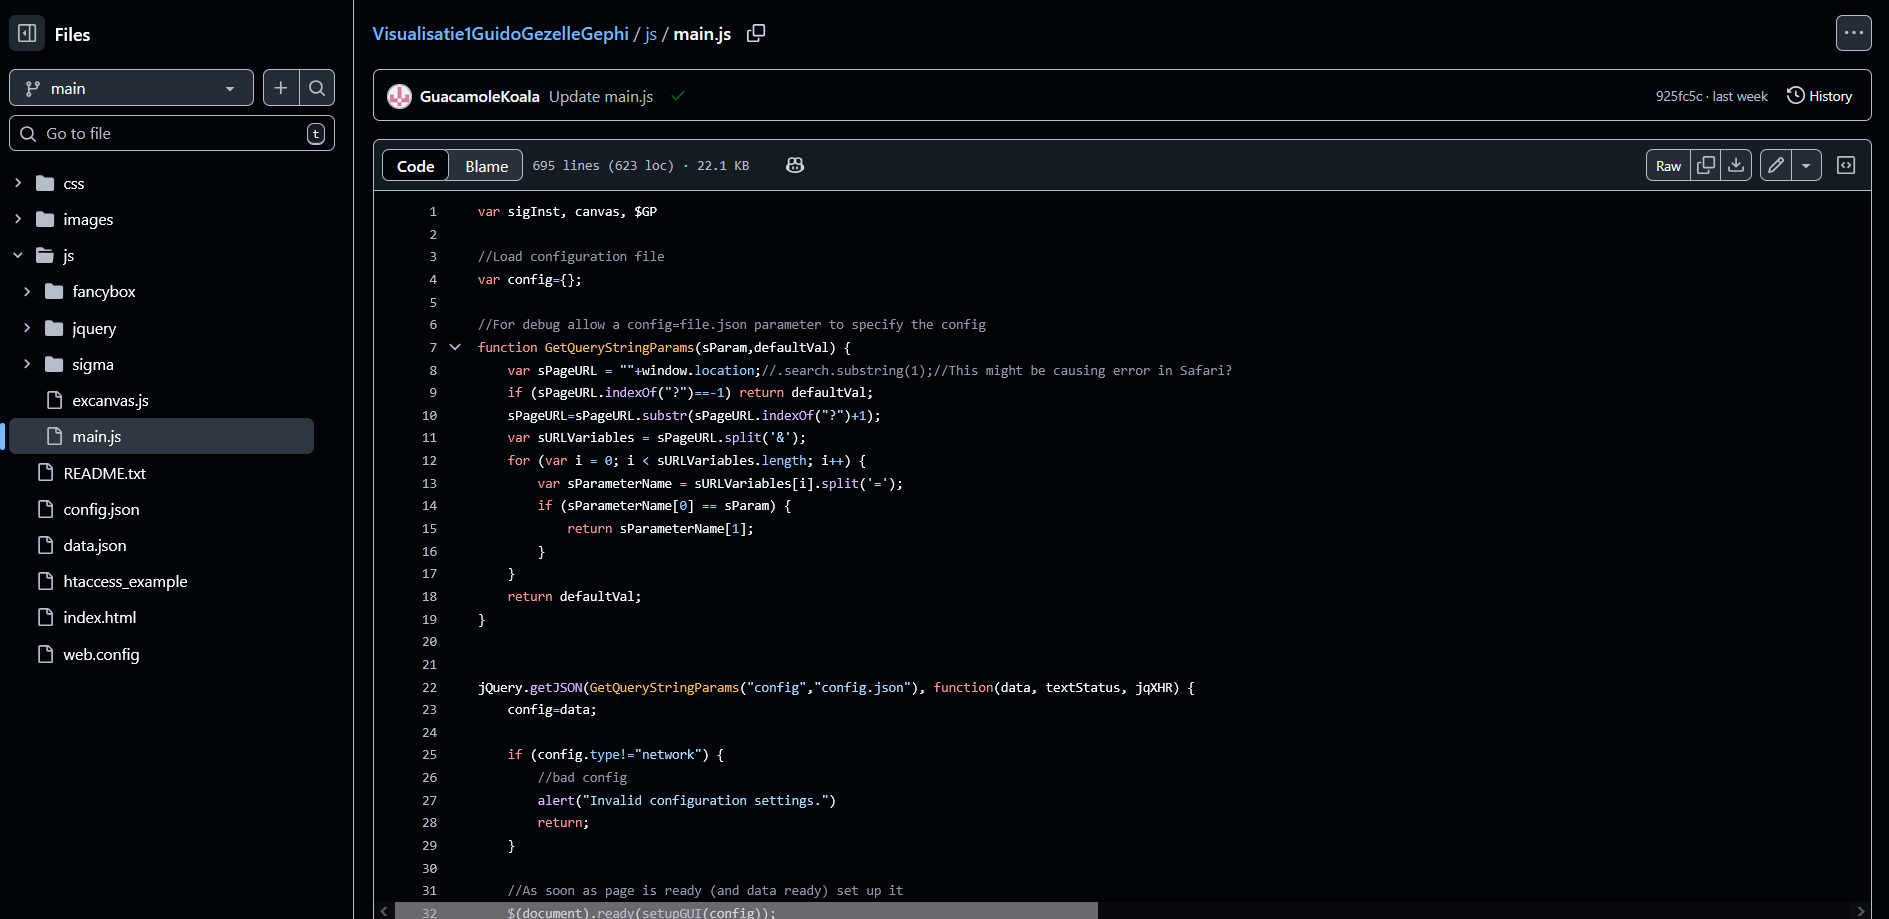

Na de aanpassingen druk je op 'commit changes'. Hier kun je ook een nota toevoegen van wat je precies hebt gedaan of verbeterd. Dit is belangrijk voor de controle van versies, indien er iets misgaat bijvoorbeeld.

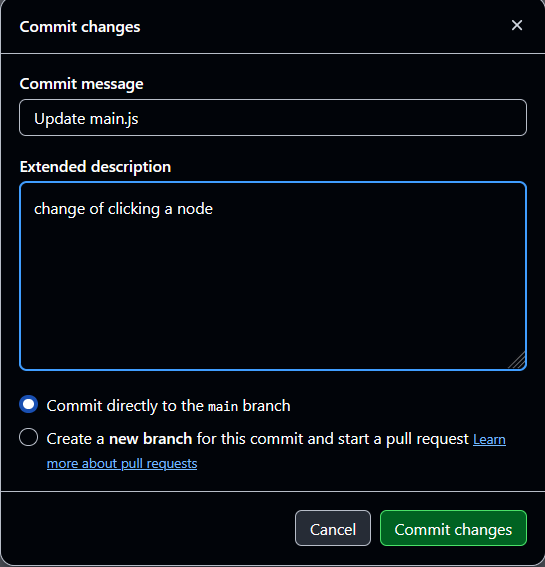

Na een paar minuten kun je de aanpassingen zien op de webpagina. Soms moet je opletten dat de browser niet een oude versie blijft herladen (door cache of cookies). Een optie is om even te wachten of in tussentijd een andere browser te proberen.

##FINAAL RESULTAAT: VISUALISATIE 4

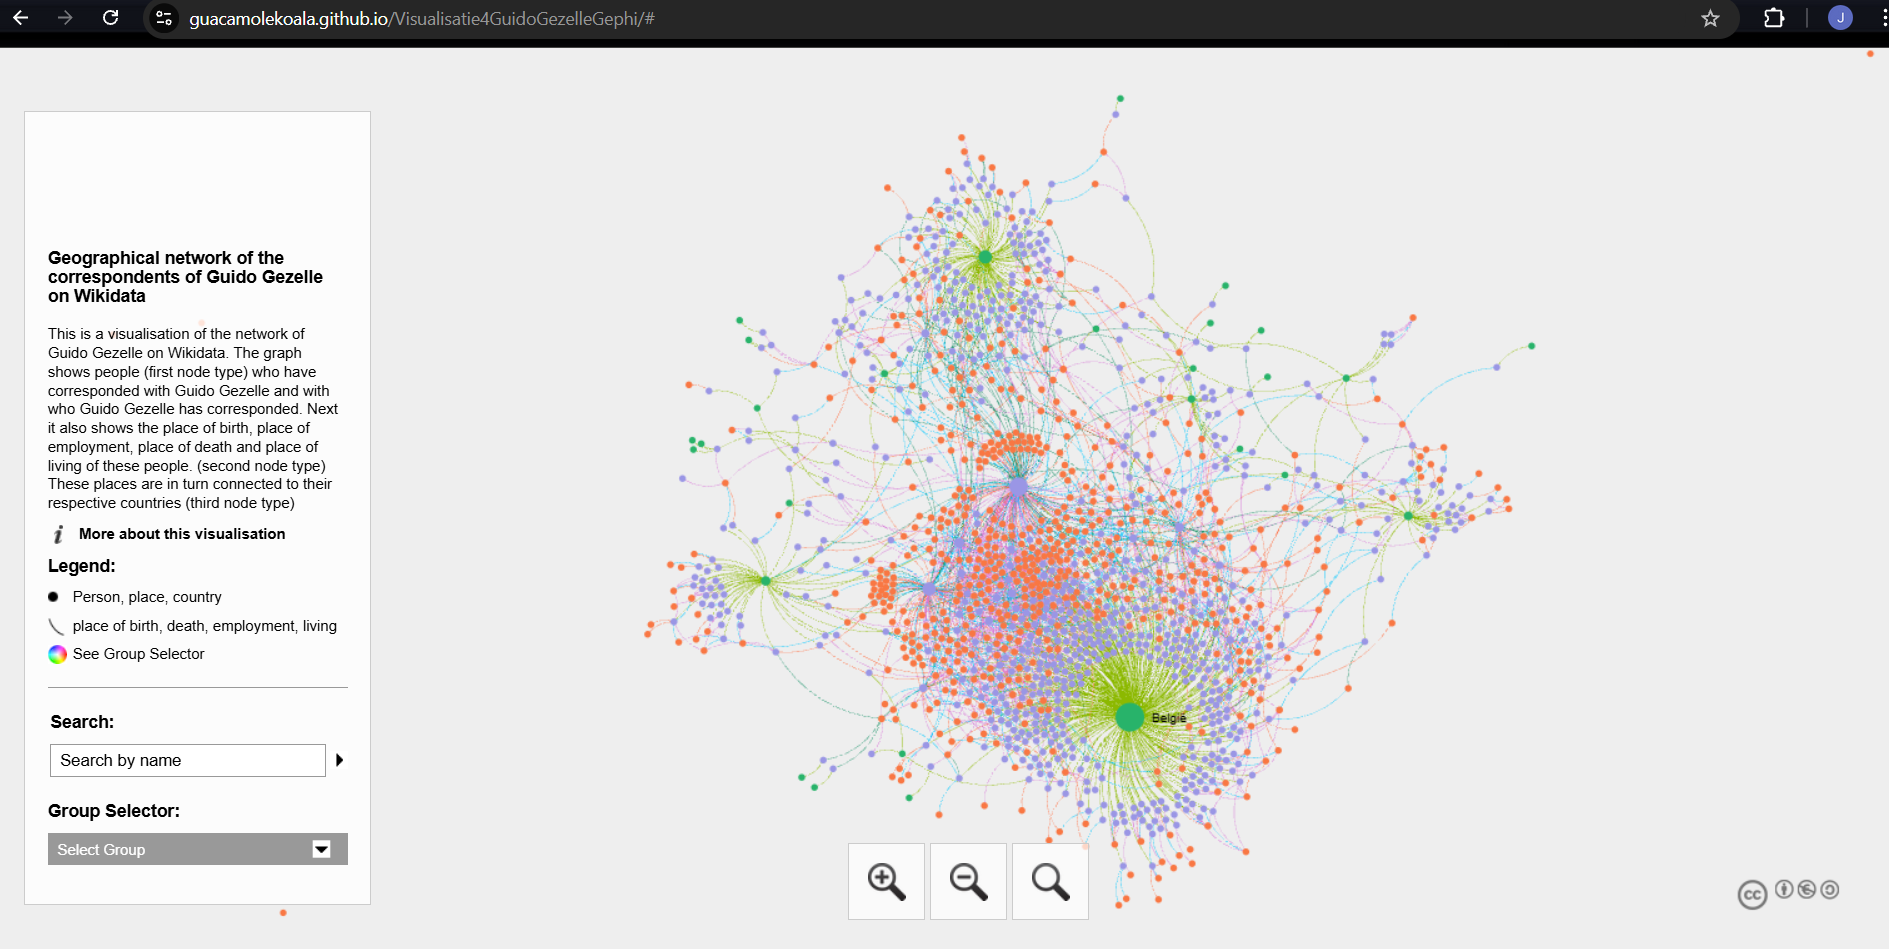

Als we op een knoop klikken, krijgen we volgend scherm:

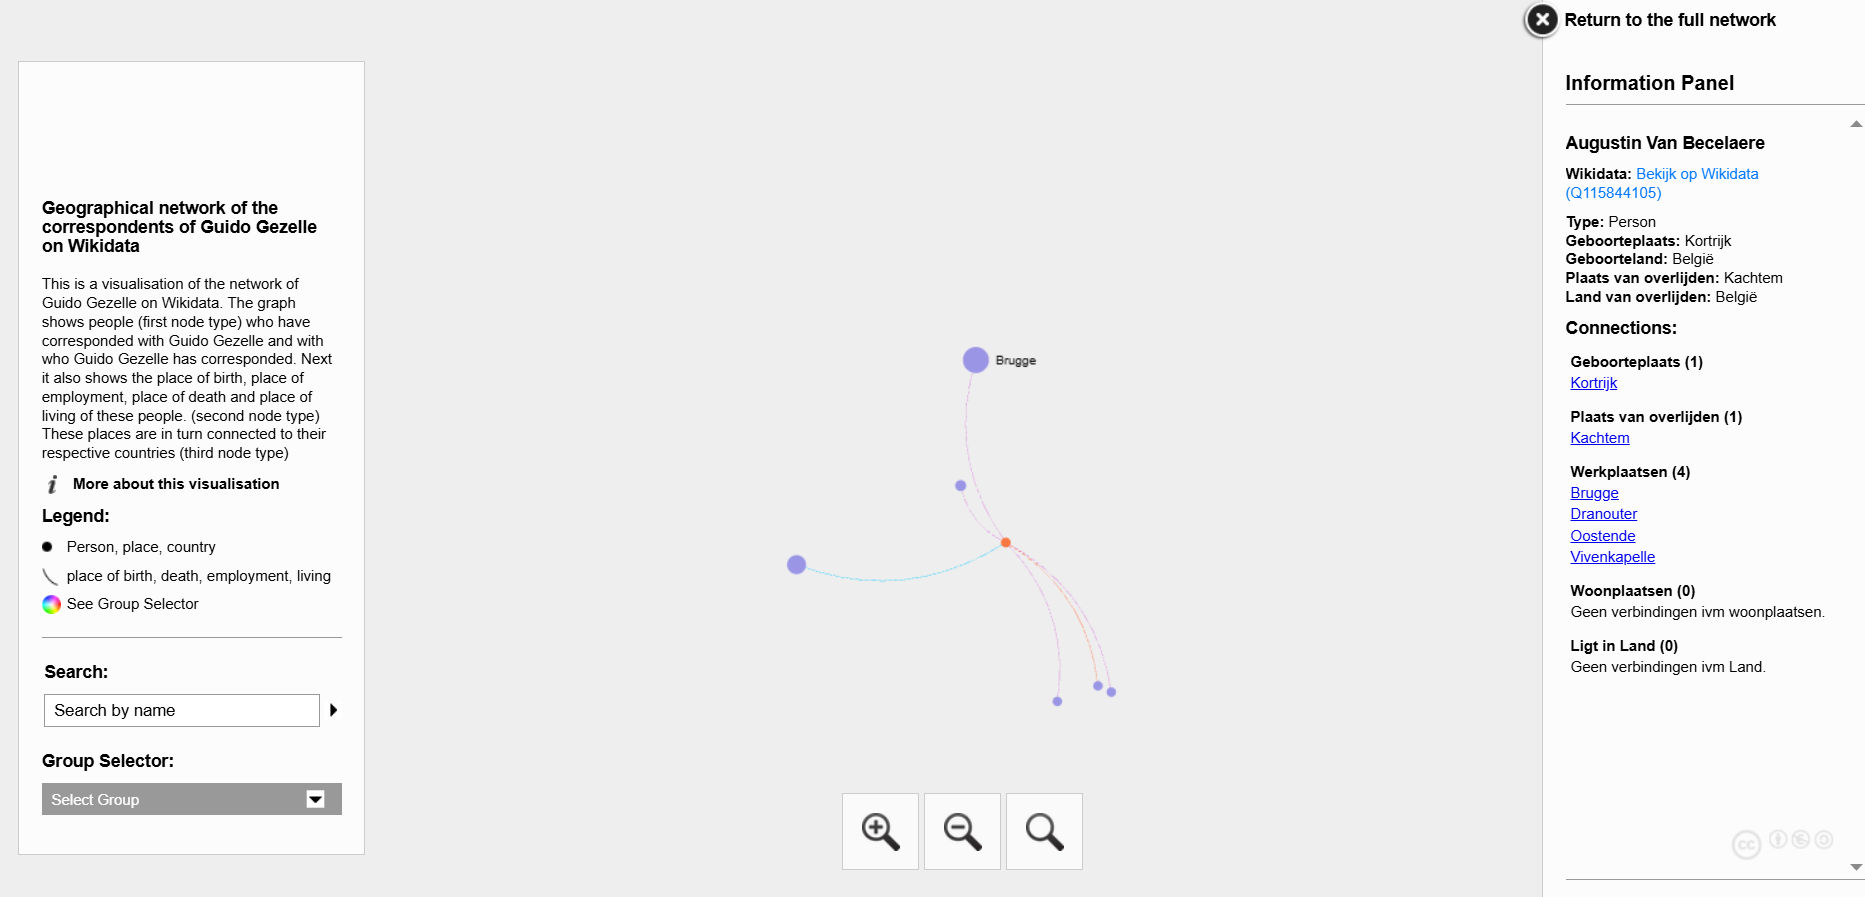

https://guacamolekoala.github.io/Visualisatie4GuidoGezelleGephi/

In deze handleiding werd een visualisatie gemaakt op basis van beschikbare data omtrent Guido Gezelle.
Eerst werden enkele queries ontworpen. Daarna werden deze via Spreadsheets omgezet naar een knopenbestand en een verbindingenbestand. Daarna werd getoond hoe deze bestanden opgeladen worden in Gephi en er een visualisatie van gemaakt wordt. Er werd stilgestaa6n bij de layout, alsook bij de export via Sigma. In een laatste fase werd de interactieve visualisatie online beschikbaar gemaakt als Github-webpagina. Met behulp van generatieve AI, in dit geval Gemini, werd de code aangepast om wat meer functionaliteit toe te voegen.

## EXTRA: VISUALISATIE 4B: GEOMAP

**overzicht stappen en plan**

In wat volgt, willen we de visualisatie hierboven verfijnen door de plaatsen en personen te koppelen aan een wereldmap. Op die manier wordt de data anders gevisualiseerd. We krijgen een duidelijk overzicht van welke plaatsen zich waar bevinden en hoeveel personen met een plaats verbonden zijn.

Hiervoor maken we eerst gebruik van twee plugins in Gephi, namelijk geolayout en map of countries. Deze twee plugins zijn echter ontoereikend om een naar onze mening degelijke interactieve visualisatie te laten zien. Om die reden wordt later gewerkt met de uitwerking van een geojson-file en een java/html script. Hieronder leggen we stap voor stap uit hoe je zo'n interactieve map maakt. Hiervoor maakten we gebruiken van Gemini 3 om een interface te bouwen.

###**Installeren plugins**

Navigeer eerst naar 'tools' in het hoofdmenu (bovenaan). Daar kun je op 'plugin' klikken. Er opent dan een menu waar je plugins kunt downloaden en activeren.

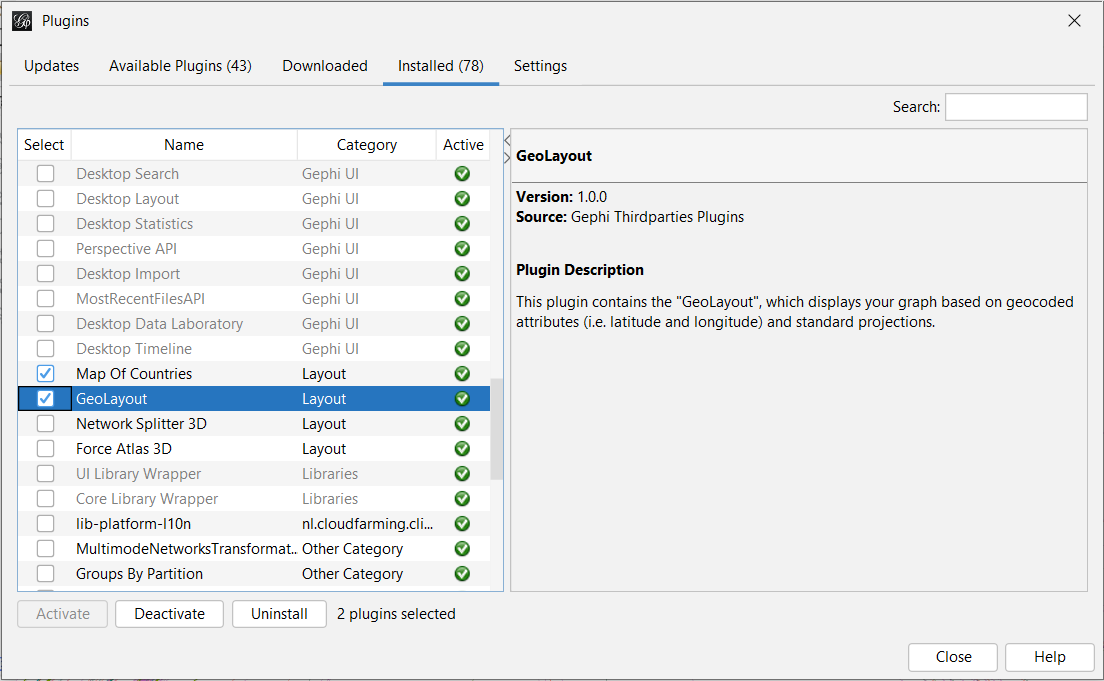

Eens je de plugin hebt gedownload, geïnstalleerd en geactiveerd, moet je Gephi herstarten. Daarna kun je in het window-menu kiezen voor 'multimode projections'. Dat opent aan de rechterkant een scherm waarin je de projectie kunt doorvoeren.

###**Openrefine: Verkrijgen van coördinaten**

Hier tonen we eerst hoe je de coordinaten kan aanvullen bij het nodes-bestand dat we eerder opstelden. Daarvoor kun je een nieuwe query opstellen die ook de coördinaten ophaalt. Hier opteren we echter voor een andere methode. In wat volgt, halen we de coördinaten van plaatsen op met behulp van software OpenRefine. OpenRefine maakt het mogelijk om data op te schonen en te verrijken, onder andere via Wikidata. Op deze manier kunnen we relatief simpel de desbetreffende informatie ophalen door de Q-nummers uit ons bestand te verbinden met hun items in Wikidata via OpenRefine. Eens de items gekoppeld zijn, kunnen we de velden met betrekking tot geografische coördinaten binnenhalen. Deze worden vervolgens bewerkt tot een breedtegraad (latitude) en lengtegraad (longitude).

Eerst exporteren we het knopenbestand vanuit Gephi van visualisatie 4.


**Exporteren nodes en edges-bestand vanuit Gephi**

Eerst en vooral is het belangrijk dat we het nodes-bestand en het edges-bestand kunnen exporteren uit Gephi. Deze twee bestanden zullen we later opladen op Github. De interface die we verderop zullen uitwerken, zal gebruik maken van deze twee bestanden. Het is daarom belangrijk dat we ze met de bewerkingen vanuit Gephi kunnen verkrijgen. Hieronder tonen we hoe de bestanden gemakkelijk en correct geëxporteerd kunnen worden.

Eerst en vooral gaan we naar het menu 'data laboratory'. Vervolgens klik je op 'export table'. Geef het document een toepasselijke naam en klik op het vakje 'opties'. Hier is het belangrijk het de knopentabel (nodes) of de tabel met verbindingen (edges) te selecteren. In de afbeelding hieronder worden de stappen nogmaals weergegeven.

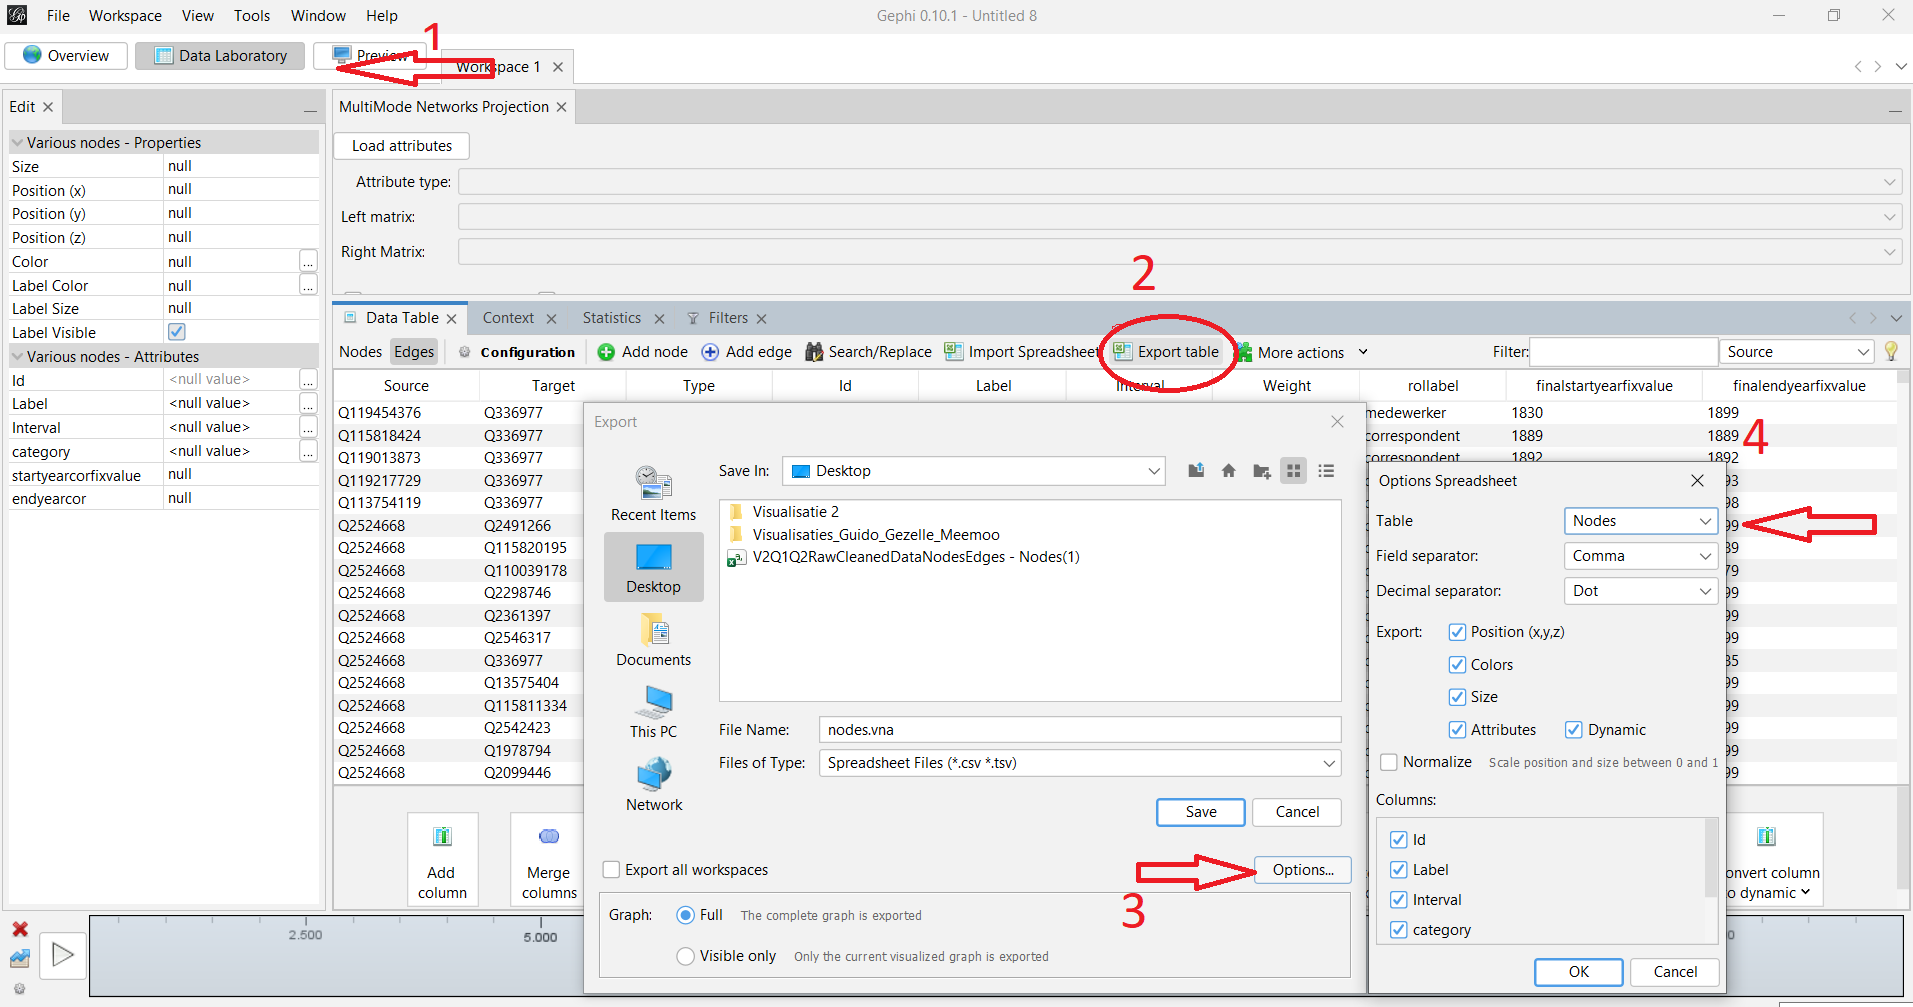

Vervolgens laden we dit bestand op in OpenRefine.
Start OpenRefine. Er start een nieuw venster in je browser. Hier kun je het document inladen. Kies voor 'choose files' en kies het knopenbestand dat we eerder in deze handleiding hebben opgesteld. Klik vervolgens op 'create project' rechts bovenaan. Nu kun je het bestand gaan bewerken.

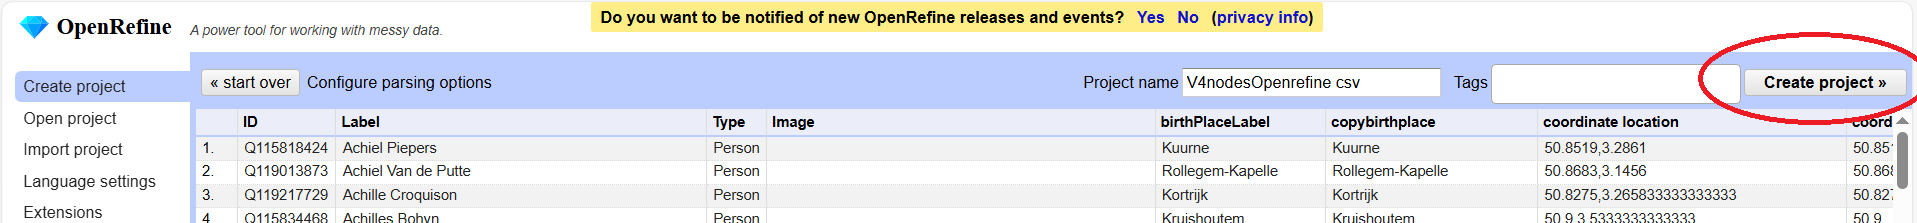

**A.Coördinaten van landen en plaatsen**

Eerst zullen we de coördinaten ophalen van alle plaatsen en landen. Hiervoor maken we een kopie van de kolom 'label'. Klik op het pijltje in de kolom 'label' en klik vervolgens op 'edit column' en dan 'add column based on this column'.

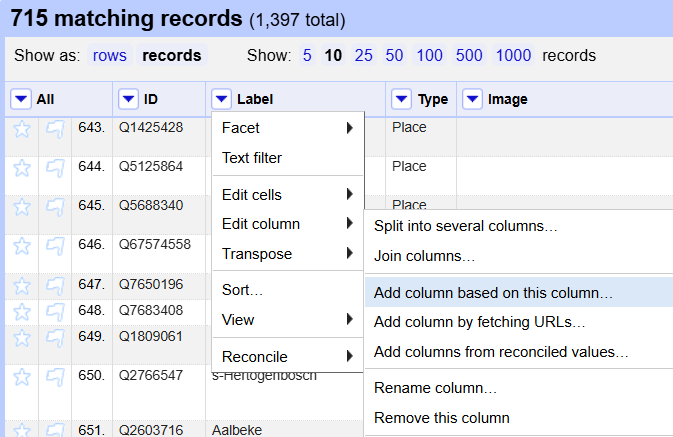

Je krijgt dit scherm te zien (onderaan). Geef de kolom een nieuwe naam (CopyLabel) en druk op ok. We willen enkel dezelfde 'value'.

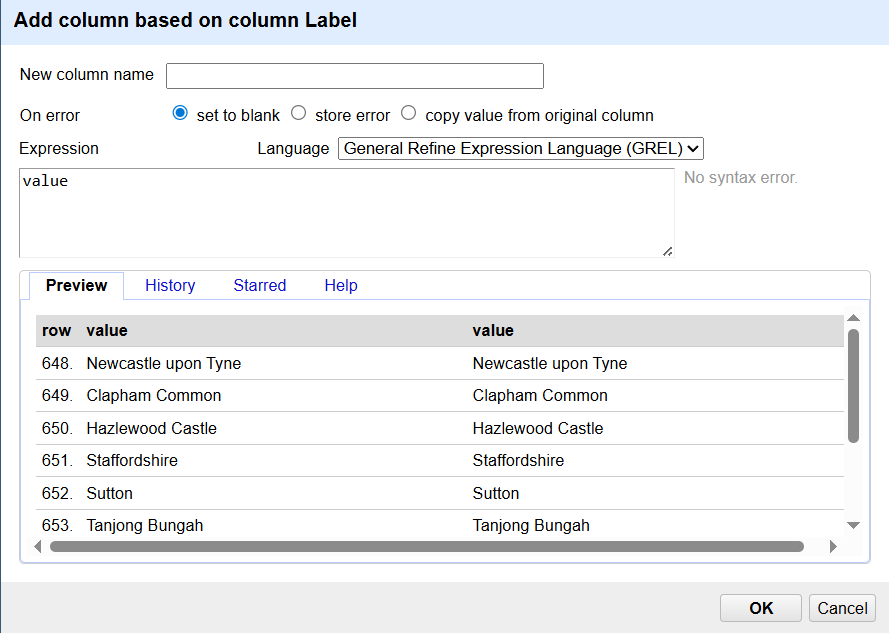

Om zeker te zijn dat we enkel de plaatsen en landen in deze fase coördinaten geven, zullen we een tekst-facet maken voor deze twee categorieënn op basis van de kolom 'type'.

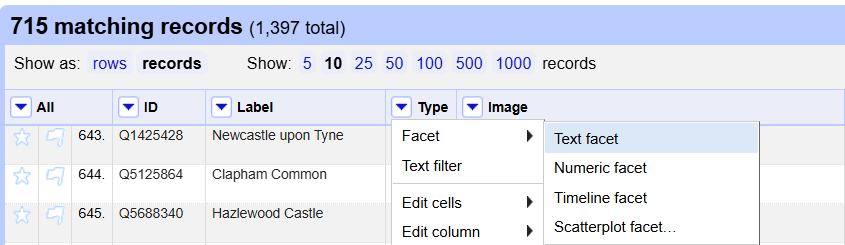

In het menu links selecteren we 'place' en 'country. Zo zullen we enkel coördinaten ophalen voor deze waarden.

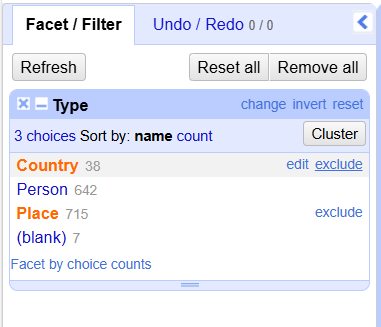

Vervolgens kunnen we de plaatsen en landen verrijken/reconciliëren door ze te verbinden met de records op Wikidata. Klik op Labels en vervolgens of 'Reconcile', klik dan op 'start reconciling'.

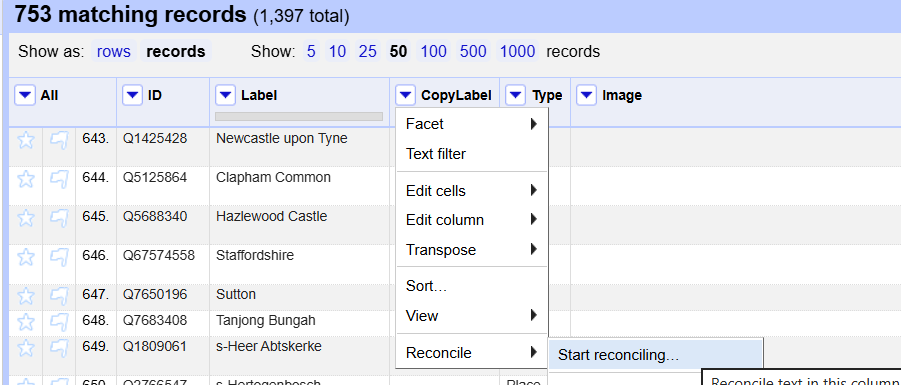

In het volgende scherm kies je om de informatie op te halen via Wikidat. Hier kun je ook andere bronnen toevoegen. Dat doen we hier niet. Druk op 'OK'. In het volgende scherm kun je kiezen voor 'reconcile against type: ' en geef zelf geographical location' in. Vergeet niet om 'auto-match' op te zetten. Opmerking: in de afbeelding gaat het om 'CopyID', maar bij ons voorbeeld wordt 'copyLabel' gebruikt.

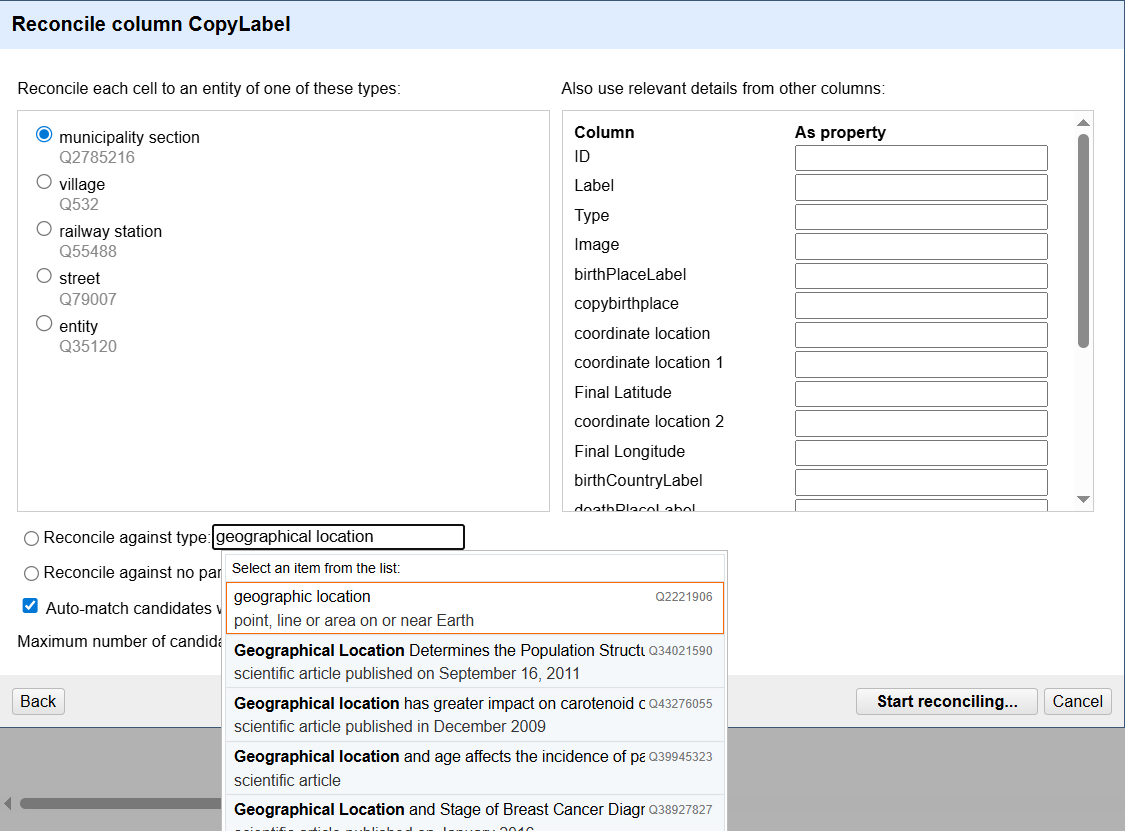

Eens je op 'start reconciling' hebt gedrukt, zal het even duren voor alle waarden gematcht zijn. Aan het einde zullen er mogelijk nog plaatsnamen zijn met meerdere mogelijk matches. Hier kun je momenteel simpelweg kiezen om elke cel te matchen met de beste kandidaat. Klik hiervoor op de pijl in de kolom van CopyLabel' en druk vervolgens op 'reconcile'-'actions'-'match each cell to its best candidate'.

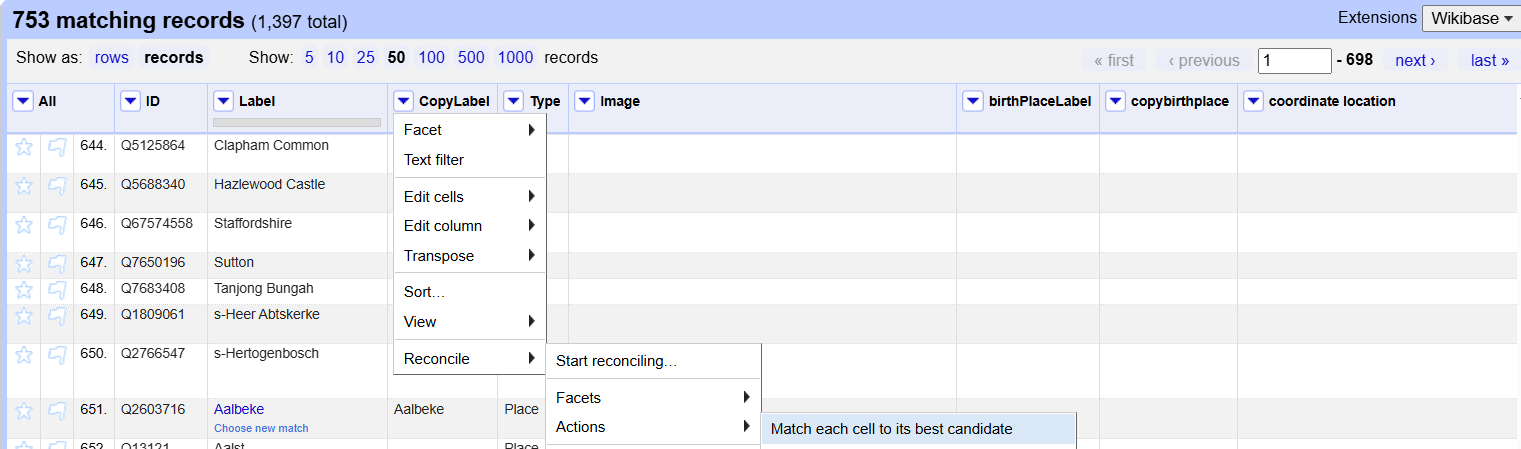

Nu we de waarden gelinkt hebben aan hun Wikidata-items, kunnen we de extra waarden omtrent coördinaten ophalen op basis van reconciliatie.

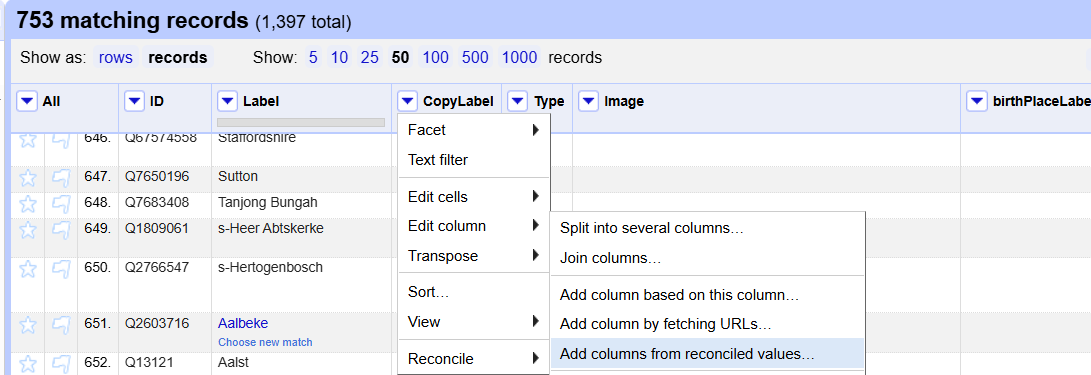

In het menu dat opent, kunnen we kiezen tussen allerlei waarden die we van het Wikidata-item kunnen toevoegen. In dit geval kiezen we voor 'Coordinate location'. In het voorbeeld hieronder werd enkel Aalbeke gereconcilieerd. Natuurlijk werden in het echte voorbeeld alle waarden gereconcilieerd.

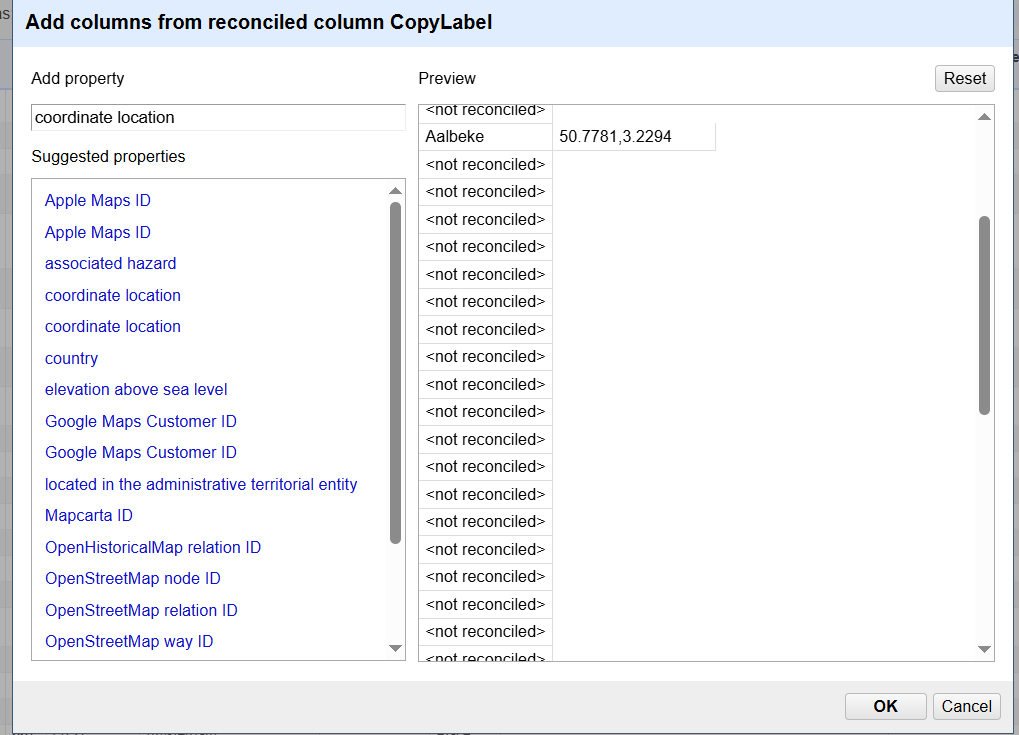

Na het proces krijgen we een extra kolom 'coordinate location' met de coördinaten van die plaats. Nu rest het ons enkel nog om deze waarde te splitsen in een lengtegraad en een breedtegraad.

Om de breedtegraad en lengtegraad extraheren, kunnen we simpelweg deze kolom splitsen in meerdere kolommen. Klik hiervoor op het pijltje in de kolom 'coordinate location' en druk vervolgens op 'edit column'-'split into several columns'.

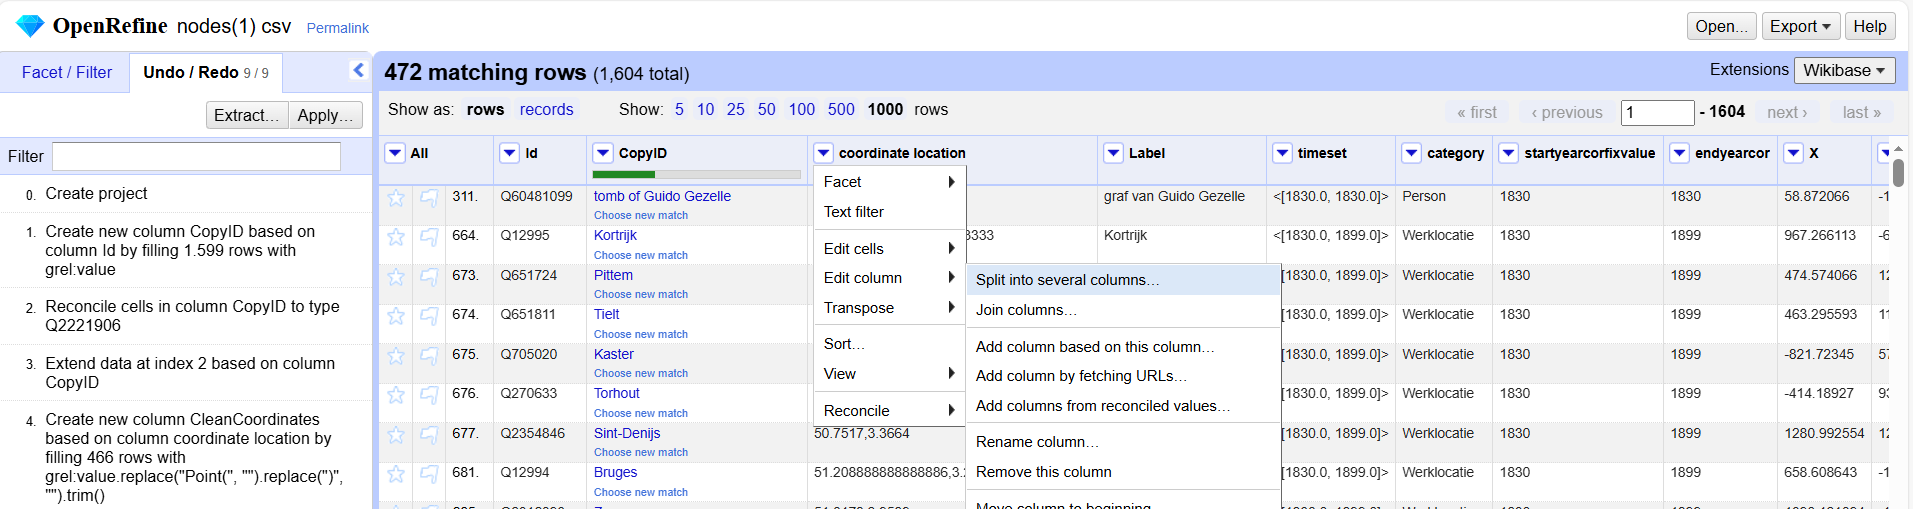

Er opent dan een venster waar we kunnen instellen om te splitsen op een komma. Dit is namelijk het onderscheidingsteken tussen de twee waarden van onze coördinaten. De eerste waarde is de breedtegraad (latitude) en de tweede waarde is de lengtegraad (longitude)

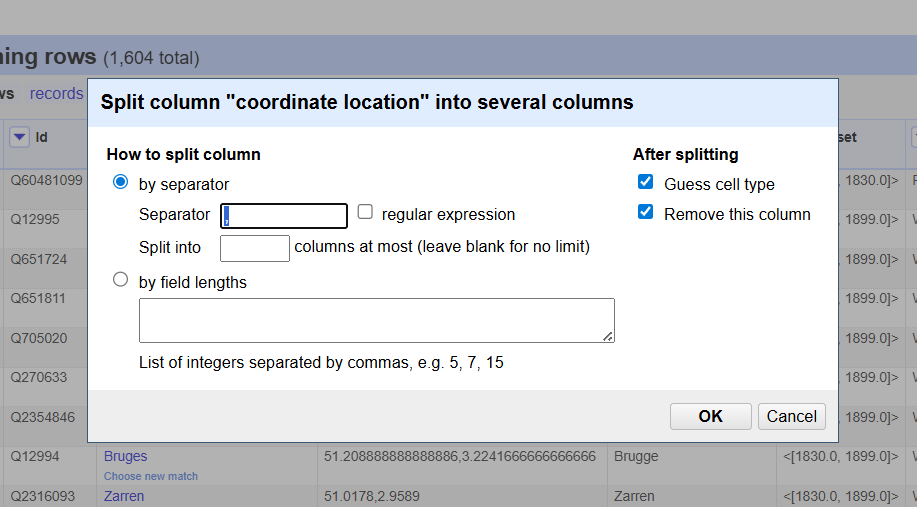

Er worden nu twee nieuwe kolommen gemaakt, namelijk coordinate location 1 en coordinate location 2. We kunnen deze kolommen hernoemen naar 'Latitude' en 'Longitude'.

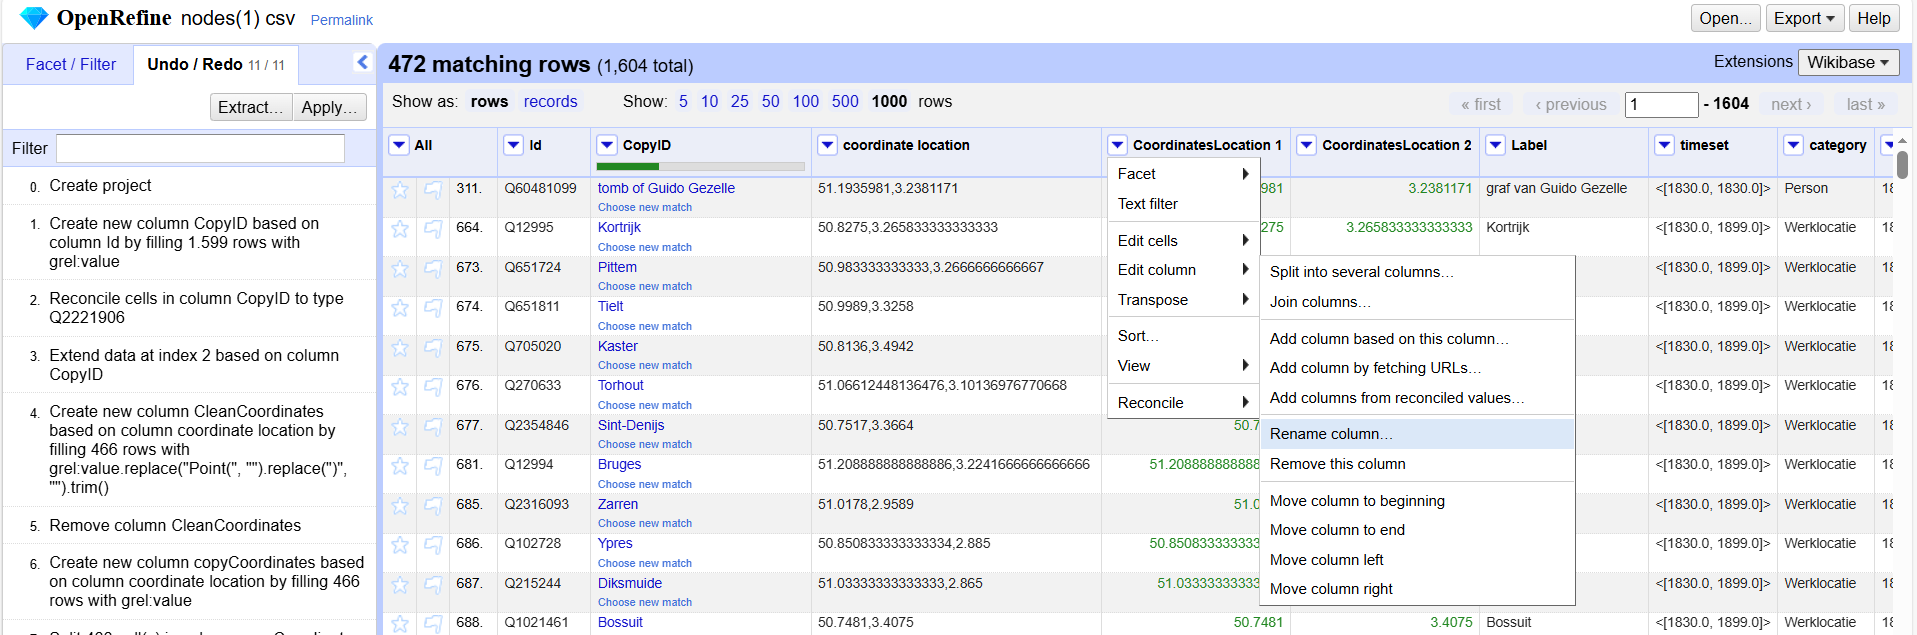

Daarna is het belangrijk er zeker van te zijn dat de waarden ingegeven zijn als nummers. Daarvoor kiezen we 'edit cells'-'common transformation'-'To number'. We doen dit voor beide kolommen (latitude en longitude).

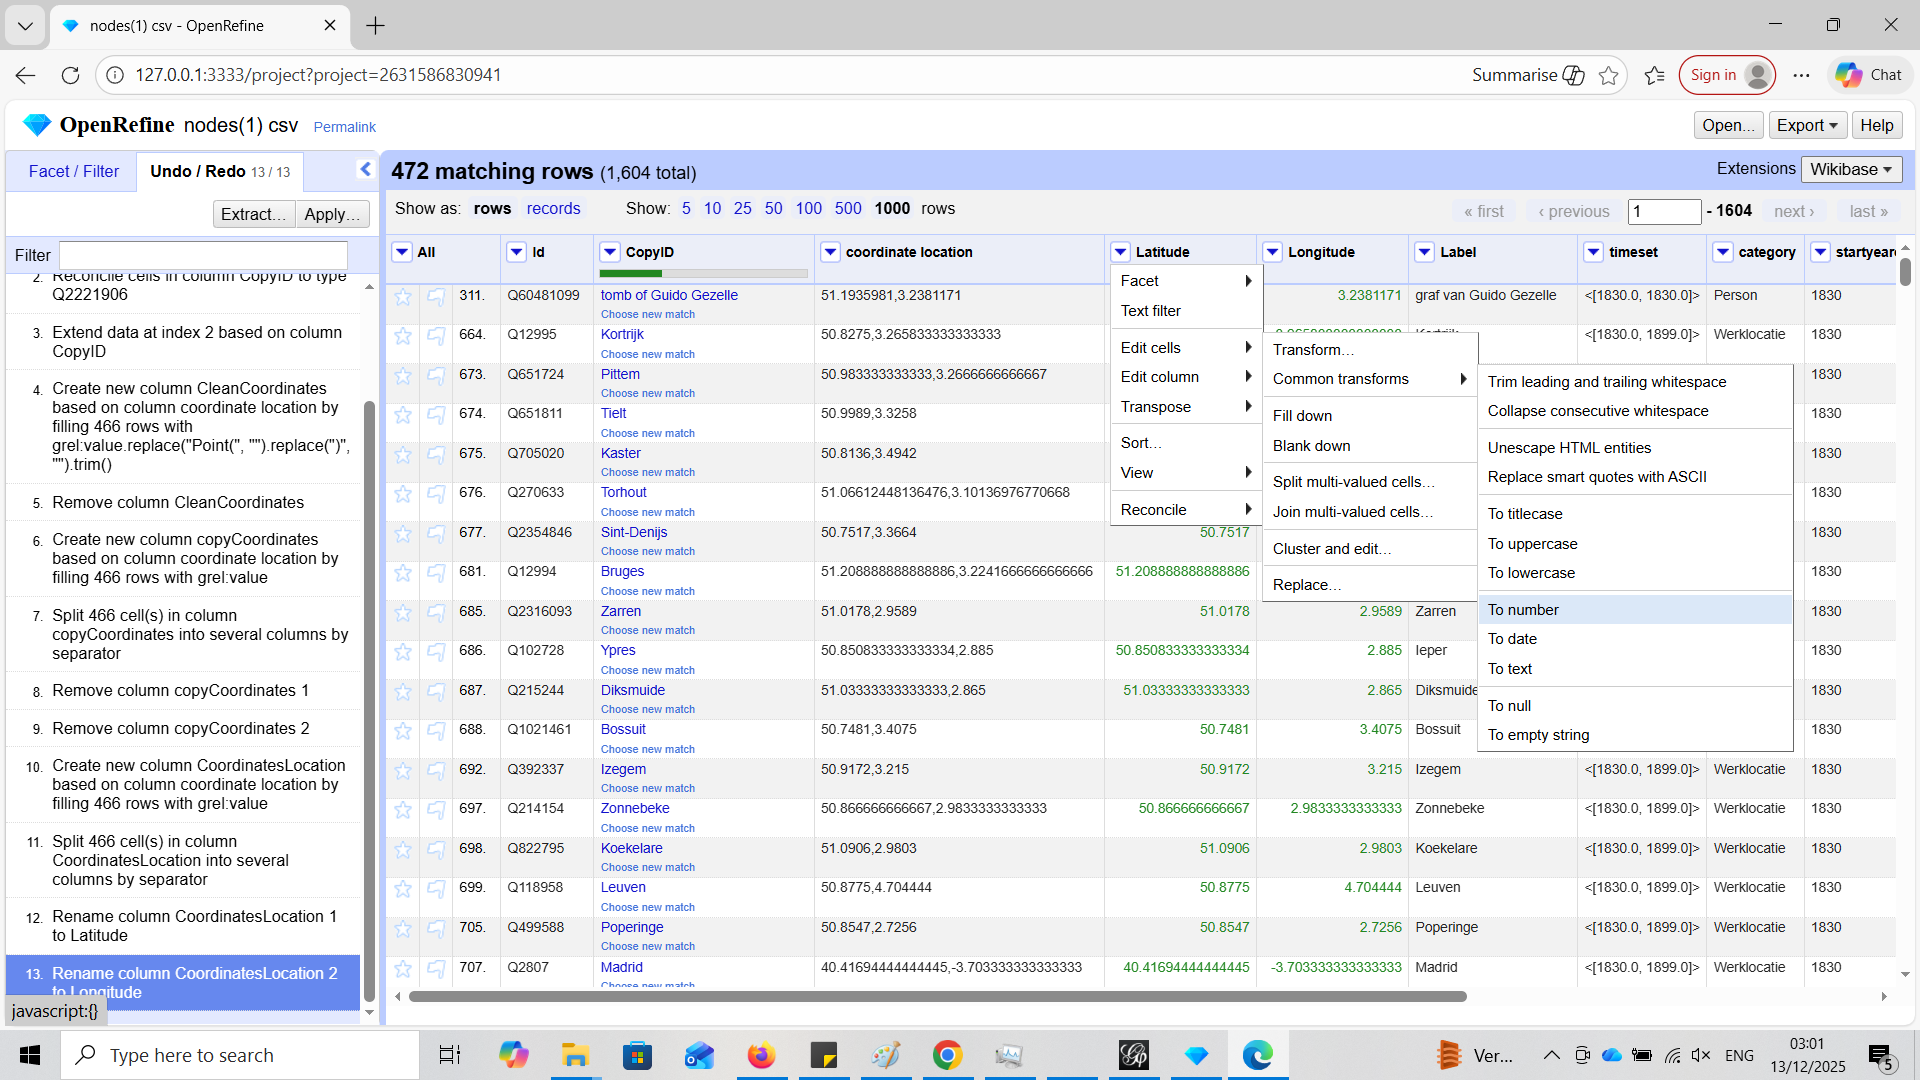

**B. Coordinaten van personen?**

De complexiteit is dat personen geen vaste locatie en coördinaten hebben. Daarom maken we hier de keuze om personen de coordinaten te geven van hun geboorteplaats. Eerst verander je het tekstfacet naar personen, zoals hierboven werd gedaan voor plaatsen en landen. Daarna maken we een kopie van de kolom geboorteplaats en geven die een niewe naam, bijvoorbeeld 'CopyBirthplace'. We reconcilieren deze kolom dan eerst op 'geographical location' en voegen we een extra kolom toe met 'coordinaten' op basis van deze gereconcilieerde waarden (zoals in het stappenplan hierboven). Vervolgens kunnen we deze verkregen kolom met coördinaten splitsen op basis van de komma. Zo krijgen we opnieuw twee kolommen met 'coordinate location 1' en 'coordinate location 2'. In wat volgt zullen we de geografische waarden van personen samenvoegen met die van de plaatsen en landen

**C. Samenvoegen van de resultaten van personen, plaatsen en landen**

Nu kunnen we de kolommen van de coordinaten van de geboorteplaats van de personen samenvoegen met de latitude en longitude die we eerder hebben opgesteld. Zo krijgt elke knoop unieke coördinaten, namelijk in termen van lengtegraad en breedtegraad. Druk hiervoor op het pijltje in de kolom van coordinate location 1 en klik op 'edit column'-'join columns'.

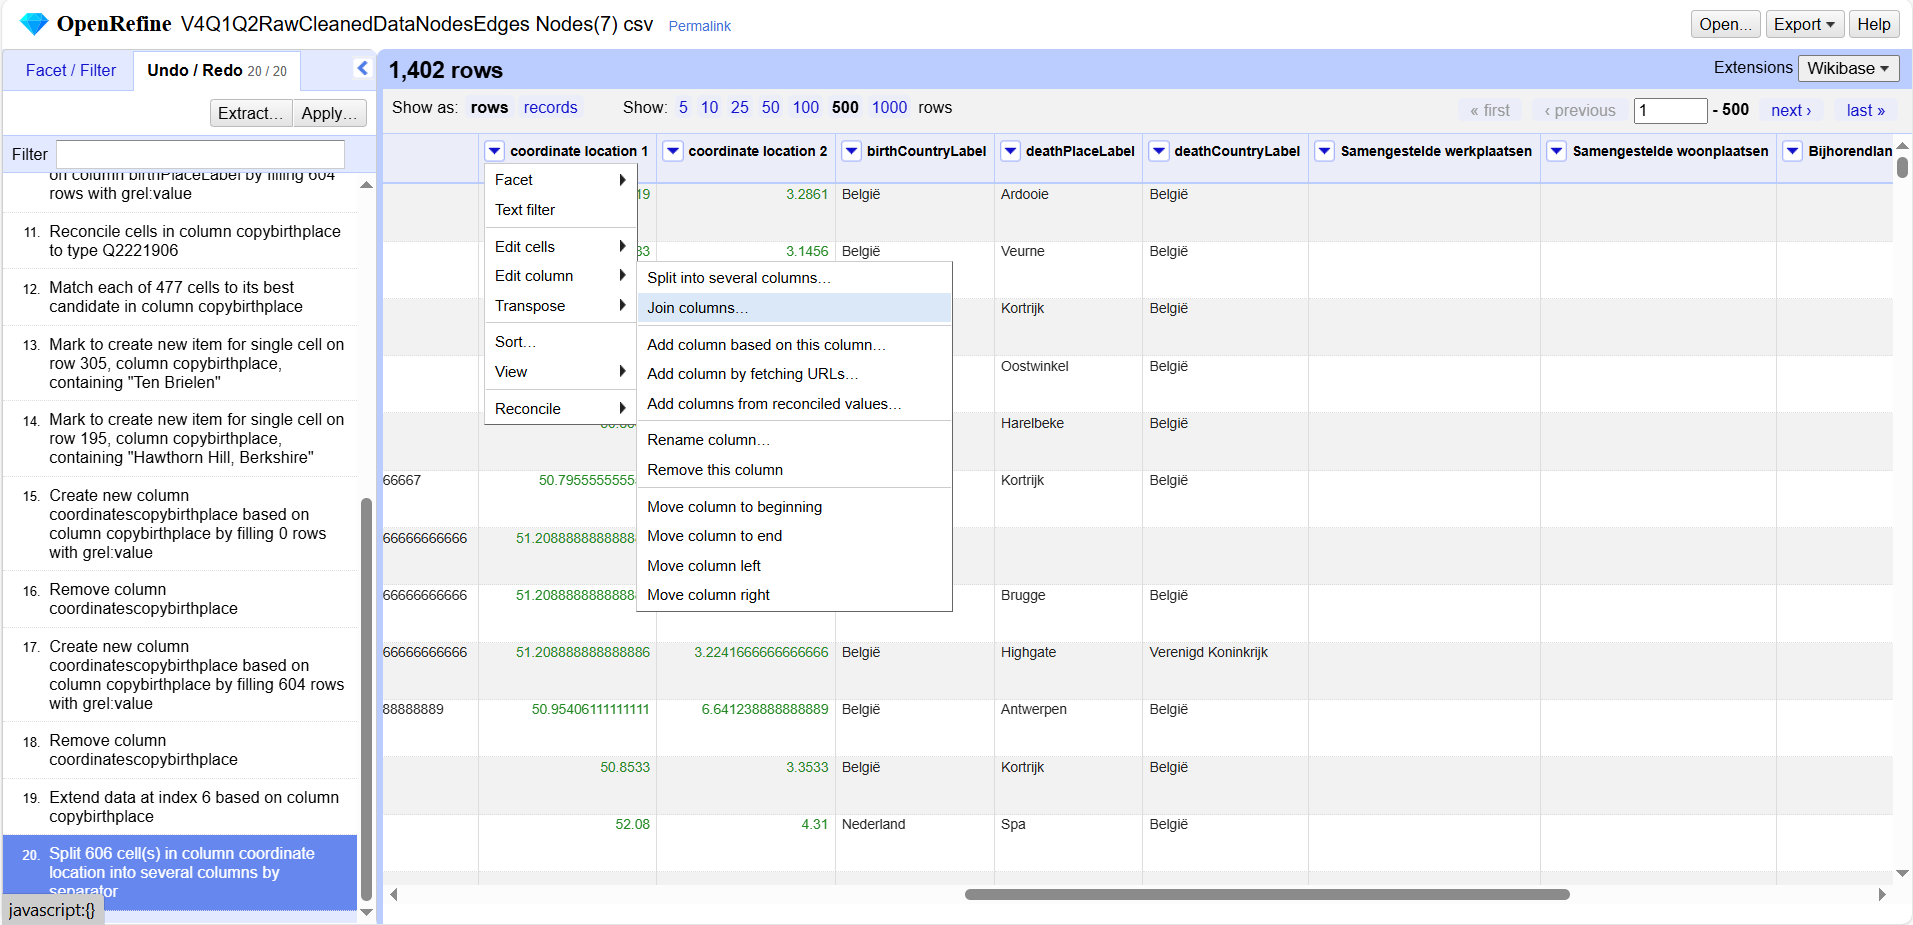

In het venster dat opent, kies je voor Coordinate location 1 en Latitude. Je kan kiezen om het resultaat in een nieuwe kolom te laten verschijnen. Druk hiervoor op 'write result in new column named' aan de rechterkant van het menu en geef de nieuwe kolomnaam in, bijvoorbeeld 'FinalLatitude'.

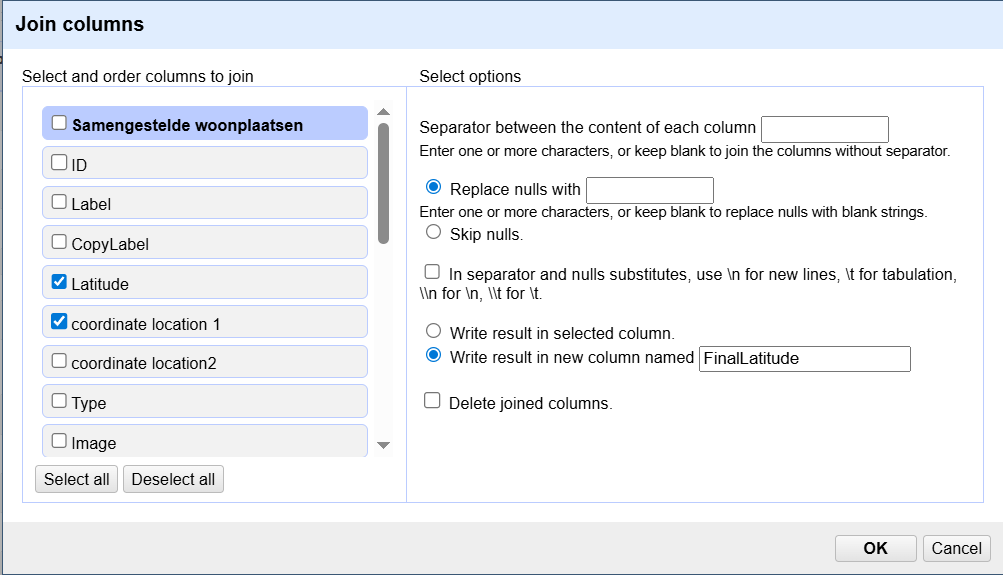

Je kan hetzelfde proces herhalen met de kolom 'coordinate location 2'. Hier kan je dan samenvoegen met 'longitude' om een nieuwe kolom te maken, bijvoorbeeld genaamd 'FinalLongitude'. Tot slot willen we zeker zijn dat deze waarden getallen zijn. Hiervoor klik je op het pijltje in de kolom 'FinalLongitude' en de kolom 'FinalLatitude' en druk vervolgens op 'edit cells' - 'common transformations'-'to number'. Doe dit voor beide kolommen.

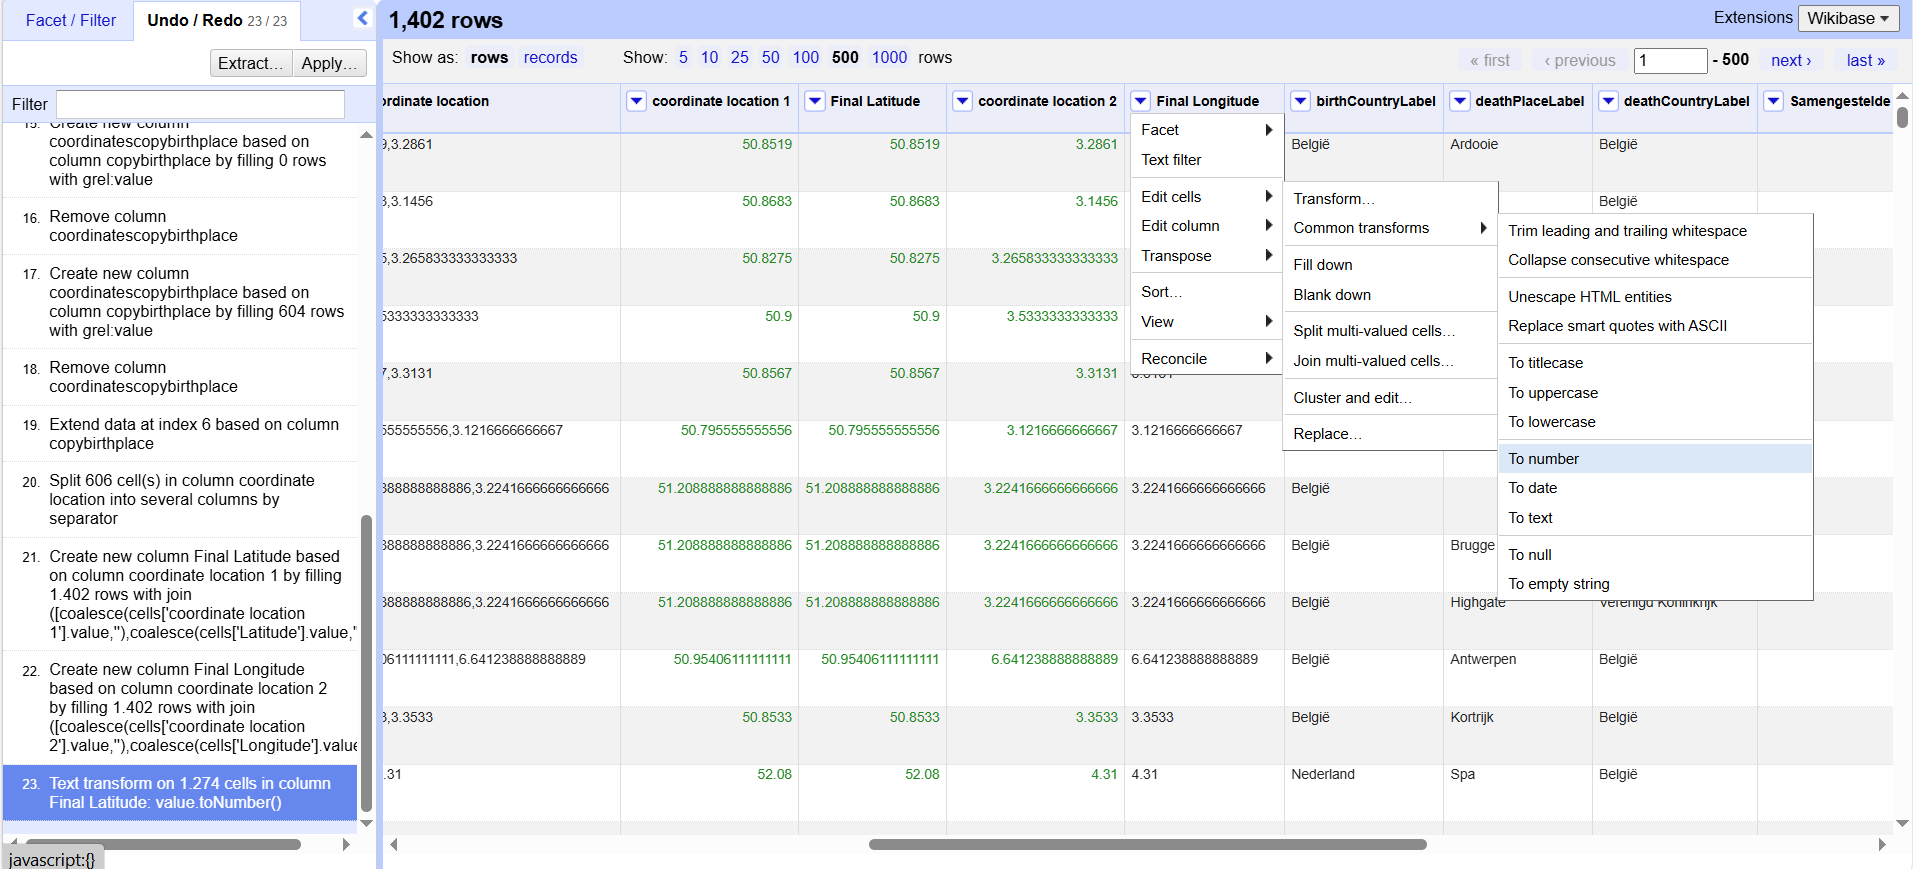

Als resultaat hebben we twee kolommen met coördinaten, namelijk breedtegraad en lengtegraad voor alle personen, plaatsen en landen. We kunnen dit verderop gebruiken.

Sla het bestand in OpenRefine op door het te exporteren. Exporteer het als OpenRefine project met een toepasselijke naam. Sla het daarnaast ook op als csv-bestand door het in dat formaat te exporteren. De knop 'export' is bovenaan rechts terug te vinden.

###**geomap maken in gephi**

Eerst kunnen we het edges-bestand en nodes-bestand inladen. Daarna visualiseren met appreance zoals hierboven, maar gebruiken geen algoritme zoals force atlas 2. We Kiezen in plaats daarvan voor geolayout en stellen voor latide en longitude respectievelijk FinalLatitude en FinalLongitude als databronnen in. Vervolgens kun je over deze mapping een tweede algoritme gebruiken. In dezelfde lijst kun je 'Map of Countries' toepassen, nadat je geo-layout hebt toegepast. Zorg er zeker voor dat beiden staan ingesteld op 'mercatormapping' (of een andere gelijkaardige map) en de grootte ook gelijk is. Ander zal de mapping niet correct gebeuren.
Zelfs met deze procedure, resulteerde dit echter in geen wenselijke resultaten.

Het grootte probleem is dat de map gegenereerd wordt door knopen die geen functie hebben. Ook is het niet simpel om overlappen tussen knopen op te lossen. Om die reden werd geopteerd voor een andere interface (zie verder).


###**Gephi bypass: geojson/python-script**

Omdat de plugins geen volwaardige interactieve visualisatie konden bieden, hebben we als alternatief geopteerd om zelf wat code te ontwikkelen met behulp van generatieve AI, in dit geval Gemini 3. Hieronder lichten we toe hoe we een interactieve map hebben gemaakt met behulp van enkele bestanden. Deze werden opgeladen op Github als webpagina en kunnen ook daar worden geraadpleegd.

In totaal hebben we 4 bestanden gemaakt: style css, index, geojson, main.js. Deze moeten samengevoegd worden in een repository om tot de gewenste interactieve visualisatie te komen. Hieronder tonen we de simpele en complexe code. Het is de bedoeling deze bestanden op te laden op Github onder een nieuw repository, bijvoorbeeld Visualisatie4BGuidoGezelle.


**A. GEOJSON**

Script voor geojson uit edges sn nodes bestand met breedtegraad en lengtegraad. Voegt deze bestanden eigenlijk samen op basis van final latitude en final longitude. laadt hierin het bewerkte nodes-bestand uit OpenRefine in, alsook het edges-bestand dat eerder in Spreadsheets werd gemaakt. Deze zullen bij de uitvoering van het script worden samengevoegd tot een nieuw bestand.

In [ ]:
Eeimport pandas as pd
import json
from google.colab import files
import io
import re
from collections import defaultdict

NODES_PATTERN = 'nodes'
EDGES_PATTERN = 'edges'
OUTPUT_GEOJSON_FILE = 'network_data_with_full_labels.geojson' # Nieuwe naam voor duidelijkheid

try:
    print("--- STAP 1: Upload Bestanden (Nodes en Edges CSV) ---")
    uploaded = files.upload()
    uploaded_keys = list(uploaded.keys())

    nodes_filename = next((k for k in uploaded_keys if NODES_PATTERN in k), None)
    edges_filename = next((k for k in uploaded_keys if EDGES_PATTERN in k), None)

    if not nodes_filename or not edges_filename:
        print("\n❌ FOUT: Niet alle verwachte bestanden zijn gevonden.")
        sys.exit(1)

    # 1. Inlezen en filteren
    nodes_df = pd.read_csv(io.BytesIO(uploaded[nodes_filename]), skipinitialspace=True)
    nodes_df.columns = nodes_df.columns.str.strip()
    edges_df = pd.read_csv(io.BytesIO(uploaded[edges_filename]), skipinitialspace=True)
    edges_df.columns = edges_df.columns.str.strip()

    nodes_df = nodes_df[nodes_df['Type'] != 'Country'].copy()
    excluded_rels = ['In Land', 'Stad ligt in land']
    edges_df = edges_df[~edges_df['relationshipType'].isin(excluded_rels)].copy()

    # 2. Opschonen en dictionary maken
    nodes_df.drop_duplicates(subset=['ID'], keep='first', inplace=True)
    nodes_df.set_index('ID', inplace=True)
    nodes_filtered = nodes_df[['Label', 'Type', 'Final Latitude', 'Final Longitude']].dropna()
    nodes_dict = nodes_filtered.to_dict('index')

    # 3. Relatie-Index Bouwen (Voor knooppunt-popups)
    relations_map = defaultdict(list)
    for _, row in edges_df.iterrows():
        src, tgt = str(row['source']), str(row['target'])
        rel_type = row['relationshipType']

        if src in nodes_dict and tgt in nodes_dict:
            src_label = nodes_dict[src]['Label']
            tgt_label = nodes_dict[tgt]['Label']

            # Relatie voor de Bron (uitgaand)
            relations_map[src].append({
                "rel": rel_type,
                "target": tgt_label,
                "dir": "naar"
            })
            # Relatie voor het Doel (inkomend)
            relations_map[tgt].append({
                "rel": rel_type,
                "target": src_label,
                "dir": "van"
            })

    # 4. GeoJSON Features Creëren
    geojson_features = []

    # A) Punten toevoegen inclusief de lijst met relaties
    for node_id, data in nodes_dict.items():
        node_relations = relations_map.get(node_id, [])
        geojson_features.append({
            "type": "Feature",
            "geometry": { "type": "Point", "coordinates": [data['Final Longitude'], data['Final Latitude']] },
            "properties": {
                "id": node_id,
                "label": data['Label'],
                "type": data['Type'],
                "relations": node_relations
            }
        })

    # B) Lijnen toevoegen MET de labels (Fix voor lijn-popup!)
    for _, row in edges_df.iterrows():
        src, tgt = str(row['source']), str(row['target'])
        if src in nodes_dict and tgt in nodes_dict:
            source_coords = nodes_dict[src]
            target_coords = nodes_dict[tgt]

            geojson_features.append({
                "type": "Feature",
                "geometry": {
                    "type": "LineString",
                    "coordinates": [
                        [source_coords['Final Longitude'], source_coords['Final Latitude']],
                        [target_coords['Final Longitude'], target_coords['Final Latitude']]
                    ]
                },
                "properties": {
                    "relationship": row['relationshipType'],
                    "source_label": source_coords['Label'], # <<< TOEGEVOEGD
                    "target_label": target_coords['Label']  # <<< TOEGEVOEGD
                }
            })

    geojson_output = {"type": "FeatureCollection", "features": geojson_features}

    # NaN opschoning
    clean_json = re.sub(r'\bNaN\b', 'null', json.dumps(geojson_output, indent=2))

    with open(OUTPUT_GEOJSON_FILE, 'w', encoding='utf-8') as f:
        f.write(clean_json)

    print(f"\n✅ Klaar! Bestand '{OUTPUT_GEOJSON_FILE}' is gecreëerd en bevat nu alle labels.")
    files.download(OUTPUT_GEOJSON_FILE)

except Exception as e:
    print(f"\n❌ FOUT: {e}")

--- STAP 1: Upload Bestanden (Nodes en Edges CSV) ---


Saving V4edges.csv to V4edges (8).csv
Saving V4nodesOpenrefine.csv to V4nodesOpenrefine (7).csv

✅ Klaar! Bestand 'network_data_with_full_labels.geojson' is gecreëerd en bevat nu alle labels.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dit bestand moet in het repository op Github geplaatst worden.

Via deze link kan de Geojson gepreviewd worden in Github: https://github.com/GuacamoleKoala/Visualisatie4BGuidoGezelle/blob/main/network_data_with_full_labels.geojson

**B. Style.css**

Dit bepaalt hoe de map eruitziet, alsook de stijl van de zijbalk, zoekvelden en popups. Je kan een nieuw bestand maken in de repository en de code daarin plakken. Vervolgens druk je om 'commit changes'.

Simpel

In [ ]:
body, html {
    height: 100%;
    margin: 0;
    padding: 0;
}

#map {
    height: 100vh; /* De kaart vult de volledige viewport hoogte */
    width: 100vw;  /* De kaart vult de volledige viewport breedte */
}

complex

In [ ]:
body, html {
    height: 100%;
    margin: 0;
    padding: 0;
}

#map {
    height: 100vh;
    width: 100vw;
}

/* NIEUWE STIJL VOOR ZIJBALK */
#sidebar {
    position: absolute;
    top: 0;
    right: 0;
    width: 300px; /* Vaste breedte */
    height: 100vh;
    background-color: white;
    padding: 15px;
    box-shadow: -2px 0 5px rgba(0,0,0,0.2);
    z-index: 1000; /* Zorg ervoor dat het boven de kaart ligt */
    overflow-y: auto; /* Scrollen mogelijk maken bij veel content */
    font-family: Arial, sans-serif;
}

#sidebar h2, #sidebar h3 {
    margin-top: 0;
    color: #333;
}

.panel {
    margin-bottom: 20px;
    padding-bottom: 10px;
    border-bottom: 1px solid #eee;
}

/* STIJL VOOR ZOEK- EN FILTERVELDEN */
#search-input, #filter-type {
    width: 100%;
    padding: 8px;
    margin: 5px 0 10px 0;
    box-sizing: border-box;
    border: 1px solid #ccc;
    border-radius: 4px;
}

/* STIJL VOOR POPUP IN KAART (voor betere leesbaarheid) */
.leaflet-popup-content {
    font-size: 13px;
    max-height: 250px;
    overflow-y: auto;
}

**Index.html**

Dit document beschrijft de structuur van de pagina, alsook de beschrijving, titel, enzovoort.

simpel

In [ ]:
<!DOCTYPE html>
<html lang="nl">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Netwerk Visualisatie - Basis</title>

    <link rel="stylesheet" href="https://unpkg.com/leaflet/dist/leaflet.css" />

    <link rel="stylesheet" href="style.css">
</head>
<body>

    <div id="map"></div>

    <script src="https://unpkg.com/leaflet/dist/leaflet.js"></script>

    <script src="script.js"></script>

    <script src="network_data_with_full_labels.geojson"></script>
</body>
</html>

Complex

In [ ]:
<!DOCTYPE html>
<html lang="nl">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Netwerk Visualisatie</title>

    <link rel="stylesheet" href="https://unpkg.com/leaflet/dist/leaflet.css" />
    <link rel="stylesheet" href="https://unpkg.com/leaflet.markercluster/dist/MarkerCluster.css" />
    <link rel="stylesheet" href="https://unpkg.com/leaflet.markercluster/dist/MarkerCluster.Default.css" />

    <link rel="stylesheet" href="style.css">

    <link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.0.0-beta3/css/all.min.css">
</head>
<body>

    <div id="map"></div>

    <div id="sidebar">
        <h2>Netwerk Analyse</h2>

        <div class="panel">
            <h3>Korte Beschrijving</h3>
            <p>
                Dit netwerk visualiseert de relaties tussen personen en locaties (steden/plaatsen) op basis van de geanalyseerde data.
                Klik op een knoop (cirkel) om de relaties te zien. Clusters geven overlappende locaties weer.
            </p>
        </div>

        <div class="panel">
            <h3>Zoeken & Filteren</h3>
            <input type="text" id="search-input" placeholder="Zoek op naam..." onkeyup="filterMap()">

            <label for="filter-type">Filter op Knooppunt Type:</label>
            <select id="filter-type" onchange="filterMap()">
                <option value="all">Toon Alles</option>
                <option value="Person">Personen</option>
                <option value="City">Plaatsen</option>
                </select>
        </div>

        <div class="panel">
            <h3>Legenda</h3>
            <div id="legend-content">
                </div>
        </div>
    </div>

    <script src="https://unpkg.com/leaflet/dist/leaflet.js"></script>
    <script src="https://unpkg.com/leaflet.markercluster/dist/leaflet.markercluster.js"></script>

    <script src="script.js"></script>
</body>
</html>

**script.js**

Deze code toont de eigenlijke werking van de interactieve visualisatie. Alle functionaliteiten zijn hier ingebed, zoals klikken op knoop, Groeperen (Marker Clustering), werking legende en search enzovoort. In wat volgt na de code, geven we een lijst van toegevoegde functionaliteiten. Opnieuw kun je deze code in een nieuw bestand plakken op Github in hetzelfde repository.

Simpel

In [ ]:
// Definieer de kaart.
const map = L.map('map').setView([50.85, 4.35], 7);

// Voeg de basiskaartlaag (tiles) toe van OpenStreetMap
L.tileLayer('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', {
    maxZoom: 19,
    attribution: '© OpenStreetMap contributors'
}).addTo(map);

// BELANGRIJK: We gebruiken de data die geladen wordt via de <script> tag in de HTML.
// Zorg ervoor dat 'network_data_with_full_labels.geojson' nog bestaat of pas de naam aan.
const data = typeof network_data_with_full_labels !== 'undefined' ? network_data_with_full_labels : null;

if (!data) {
    console.error("GeoJSON data niet gevonden. Controleer de bestandsnaam in index.html.");
} else {
    // Functie om de styling van de punten (Nodes) te bepalen
    function styleNodes(feature) {
        const type = feature.properties.type;
        let color = '#3388ff'; // Standaard blauw (voor Locaties/Cities)
        let radius = 6;

        // Pas de kleur en grootte aan op basis van het Type
        if (type === 'Person') {
            color = '#E91E63'; // Roze
            radius = 4;
        } else if (type === 'Country') {
             color = '#4CAF50'; // Groen (optioneel, indien niet gefilterd in Python)
             radius = 8;
        }

        return {
            radius: radius,
            fillColor: color,
            color: "#000", // Zwarte rand
            weight: 1,
            opacity: 1,
            fillOpacity: 0.8
        };
    }

    // Functie om de styling van de lijnen (Edges) te bepalen
    function styleEdges(feature) {
        // Heel simpele styling voor lijnen
        return {
            color: '#888', // Grijs
            weight: 1,
            opacity: 0.8 // Lichtere kleur voor lijnen
        };
    }

    // Functie om popups toe te voegen wanneer op een feature wordt geklikt
    function onEachFeature(feature, layer) {
        let popupContent = "";

        if (feature.geometry.type === 'Point') {
            // Knooppunt (Point) - Basisinformatie
            popupContent = `
                <b>Knooppunt:</b> ${feature.properties.label}<br>
                <b>ID:</b> ${feature.properties.id}<br>
                <b>Type:</b> ${feature.properties.type || 'Onbekend'}
            `;
        } else if (feature.geometry.type === 'LineString') {
            // Rand (LineString) - Basisinformatie over de relatie
            popupContent = `
                <b>Relatie:</b> ${feature.properties.relationship}<br>
                Van: ${feature.properties.source_label || feature.properties.source_id}<br>
                Naar: ${feature.properties.target_label || feature.properties.target_id}
            `;
        }

        layer.bindPopup(popupContent);
    }

    // Voeg de GeoJSON-data toe aan de kaart
    const geoLayer = L.geoJSON(data, {
        // Styling voor punten (Nodes)
        pointToLayer: function (feature, latlng) {
            if (feature.geometry.type === 'Point') {
                 return L.circleMarker(latlng, styleNodes(feature));
            }
            return null;
        },
        // Styling voor lijnen (Edges)
        style: styleEdges,
        // Popups voor alle features
        onEachFeature: onEachFeature
    }).addTo(map);

    // Pas de kaart aan om alle data in beeld te brengen
    map.fitBounds(geoLayer.getBounds());
}

Uitgebreid/aangepast

In [ ]:
// Variabelen voor de kaart en data
const map = L.map('map').setView([50.85, 4.35], 7);
L.tileLayer('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png').addTo(map);

const markers = L.markerClusterGroup({
    spiderfyOnMaxZoom: true,
    showCoverageOnHover: false,
    zoomToBoundsOnClick: true
});

let fullGeoJsonData = null;
let geoJsonLayer = null;

// Definieer de kleuren voor de legenda
const nodeColors = {
    'Person': '#E91E63',
    'City': '#3388ff',
};

// NIEUWE FUNCTIE: Bepaalt het Type voor consistentie, kleur en filtering
function getNodeType(originalType) {
    if (originalType === 'Person') {
        return 'Person';
    }
    // Alle andere types (Location, Town, City, etc.) worden behandeld als 'City' (Plaats)
    return 'City';
}

// --- FUNCTIES VOOR INTERACTIE ---

function generateNodePopupHtml(props) {
    // Deze functie blijft identiek, de logica zit in het Python script en de filtering
    let popupHtml = `<div class="node-popup">
        <h3>${props.label}</h3>
        <p><b>Type:</b> ${getNodeType(props.type)}</p>
        <hr>
        <b>Relaties (${props.relations ? props.relations.length : 0}):</b><br>
        <ul style="max-height: 150px; overflow-y: auto; padding-left: 20px;">`;

    const sortedRelations = props.relations ? props.relations.sort((a, b) => a.dir.localeCompare(b.dir)) : [];

    if (sortedRelations.length > 0) {
        sortedRelations.forEach(rel => {
            const directionText = rel.dir === "naar" ? 'gaat naar' : 'komt van';
            const icon = rel.dir === "naar" ? '<i class="fas fa-arrow-right"></i>' : '<i class="fas fa-arrow-left"></i>';
            popupHtml += `<li>${icon} <i>${rel.rel}</i> ${directionText} <b>${rel.target}</b></li>`;
        });
    } else {
        popupHtml += "<li>Geen directe relaties gevonden.</li>";
    }
    popupHtml += `</ul></div>`;
    return popupHtml;
}

function generateLinePopupHtml(props) {
     return `
        <h3>Relatie Detail</h3>
        <p><b>Relatie Type:</b> ${props.relationship}</p>
        <hr>
        <p><b>Van:</b> ${props.source_label || 'Onbekend'}</p>
        <p><b>Naar:</b> ${props.target_label || 'Onbekend'}</p>
    `;
}

function onEachFeature(feature, layer) {
    if (feature.geometry.type === 'LineString') {
        layer.bindPopup(generateLinePopupHtml(feature.properties), { minWidth: 200 });
    }
}


// --- FUNCTIES VOOR KAART WEERGAVE EN FILTERING ---

function drawMap(data) {
    if (geoJsonLayer) { map.removeLayer(geoJsonLayer); }
    markers.clearLayers();

    const filteredFeatures = data.features.filter(f => f.visible);

    geoJsonLayer = L.geoJSON({
        type: 'FeatureCollection',
        features: filteredFeatures
    }, {
        pointToLayer: (feature, latlng) => {
            if (feature.geometry.type === 'Point') {
                const props = feature.properties;
                // GEFIXTE KLEURTOEWIJZING
                const type = getNodeType(props.type);
                const color = nodeColors[type] || '#888';

                const marker = L.circleMarker(latlng, {
                    radius: 7,
                    fillColor: color,
                    color: "#000",
                    weight: 1,
                    fillOpacity: 0.8
                });

                marker.bindPopup(generateNodePopupHtml(props), { minWidth: 250 });
                markers.addLayer(marker);
                return null;
            }
            return null;
        },
        style: (feature) => {
            if (feature.geometry.type === 'LineString') {
                return { color: '#888', weight: 1, opacity: 0.3 };
            }
            return {};
        },
        onEachFeature: onEachFeature
    });

    map.addLayer(markers);
    geoJsonLayer.addTo(map);

    if (markers.getLayers().length > 0) {
         map.fitBounds(markers.getBounds(), { padding: [50, 50] });
    } else if (geoJsonLayer.getLayers().length > 0) {
        map.fitBounds(geoJsonLayer.getBounds(), { padding: [50, 50] });
    }
}

// Functie voor filteren en zoeken
window.filterMap = function() {
    if (!fullGeoJsonData) return;

    const searchTerm = document.getElementById('search-input').value.toLowerCase();
    const filterType = document.getElementById('filter-type').value;

    const filteredData = JSON.parse(JSON.stringify(fullGeoJsonData));

    filteredData.features.forEach(feature => {
        feature.visible = true;
        const props = feature.properties;

        if (feature.geometry.type === 'Point') {
            const label = props.label ? props.label.toLowerCase() : '';
            const nodeType = getNodeType(props.type); // Gebruik de geconsolideerde type

            if (searchTerm && !label.includes(searchTerm)) {
                feature.visible = false;
            }

            // GEFIXTE FILTERLOGICA
            if (feature.visible && filterType !== 'all') {
                if (filterType === 'Person' && nodeType !== 'Person') {
                    feature.visible = false;
                } else if (filterType === 'City' && nodeType !== 'City') {
                    feature.visible = false;
                }
            }
        }
    });

    drawMap(filteredData);
};

// Functie om de legenda te vullen (nu met consistente types)
function createLegend() {
    const legendContent = document.getElementById('legend-content');
    let html = '<h4>Knooppunten (Locaties/Personen)</h4>';

    // We definiëren de types nu hier om consistent te zijn met getNodeType
    const typesForLegend = {'Person': '#E91E63', 'Plaats': '#3388ff'};

    for (const type in typesForLegend) {
        const color = typesForLegend[type];
        html += `<div style="display: flex; align-items: center; margin-bottom: 5px;">
            <span style="display: inline-block; width: 12px; height: 12px; border-radius: 50%; background-color: ${color}; border: 1px solid #000; margin-right: 8px;"></span>
            <span>${type}</span>
        </div>`;
    }

    html += '<h4 style="margin-top: 15px;">Lijnen (Relaties)</h4>';
    html += `<div style="display: flex; align-items: center;">
        <span style="display: inline-block; width: 30px; height: 2px; background-color: #888; margin-right: 8px;"></span>
        <span>Aangetoonde relatie</span>
    </div>`;

    legendContent.innerHTML = html;
}

// Start de applicatie - gebruik de correcte bestandsnaam
fetch('network_data_with_full_labels.geojson') // Dit is de laatst bekende, correcte naam
    .then(res => res.json())
    .then(data => {
        fullGeoJsonData = data;
        fullGeoJsonData.features.forEach(f => f.visible = true);

        drawMap(fullGeoJsonData);
        createLegend();
    })
    .catch(error => {
        console.error('Fout bij het laden van de GeoJSON data:', error);
    });

**Overzicht van toegevoegde functionaliteiten**

Er werd steeds een simpele en complexe code getoond. De reden hiervoor is dat we meer functionaliteiten zijn gaan toevoegen naarmate we meer dialoog maakten met Gemini. Hieronder geven we een overzicht van welke toevoegingen we hebben gedaan aan de interface en aan het script.

 I. Basis Visualisatie & StructuurGeografische Weergave: Gebruikt Leaflet.js om knooppunten (personen/plaatsen) en relaties (lijnen) over een OpenStreetMap basiskaart te projecteren.Gestructureerde UI: De applicatie is verdeeld in de Kaart links en een Interactieve Zijbalk rechts.Gekleurde Knooppunten (Legenda): De kleuren van de cirkels geven het type knooppunt aan, wat wordt verklaard in de Legenda:Roze ($\text{#E91E63}$): Personen (Person).Blauw ($\text{#3388ff}$): Plaatsen (City) - Dit omvat alle locaties, ongeacht of ze oorspronkelijk 'City', 'Town' of 'Location' waren.Lijnen (Edges): Grijze lijnen verbinden gerelateerde knooppunten.

 II. Navigatie & InteractieA. Clustering (Spiderfication)Overlapbeheer: In plaats van dat honderden bolletjes elkaar overlappen op één plek (zoals een grote stad), worden nabije knooppunten automatisch gegroepeerd in een cluster (een grotere bol met een getal).Uitspreiden (Spiderfication): Door op een cluster te klikken, worden de individuele, overlappende knooppunten uitgespreid in een cirkelvormig patroon, waardoor ze afzonderlijk aanklikbaar worden.B. Zoeken en Filteren (Zijbalk)De zijbalk biedt dynamische controle over de getoonde knooppunten:Zoekbalk: Zoeken op tekst (bijv. naam of plaats) om de kaart te filteren en alleen knooppunten te tonen die de zoekterm bevatten.Type Filter: Filteren op de twee geconsolideerde types:Toon Alles: Toont alle knooppunten en relaties.Personen: Toont alleen knooppunten van het type Person en hun relaties.Plaatsen: Toont alleen knooppunten van het type City (of een andere locatie) en hun relaties.

 III. Informatie en DetailweergaveA. Knooppunt-Popups (Cirkel Klik)Wanneer u op een individueel knooppunt (cirkel) klikt, verschijnt er een gedetailleerde popup met:Label en Type: De naam en het type (Persoon/Plaats).Volledige Relatielijst: Een gesorteerde lijst van alle in- en uitgaande relaties van dat knooppunt.Inkomend: Wordt duidelijk aangegeven, bijvoorbeeld door de tekst "komt van" en een linkerpijl (<i class="fas fa-arrow-left"></i>).Uitgaand: Wordt duidelijk aangegeven, bijvoorbeeld door de tekst "gaat naar" en een rechterpijl (<i class="fas fa-arrow-right"></i>).Relatietype: Toont de aard van de verbinding (bv. 'Geboorteplaats', 'Woonplaats', 'Werklocatie').B. Relatie-Popups (Lijn Klik)Wanneer u op een lijn (relatie/edge) klikt, verschijnt er een simpele popup die de details van die specifieke verbinding uitlegt:Relatietype: Het type relatie (bv. Woonplaats).Van (Source): De naam van het bronknooppunt (waar de relatie vandaan komt).Naar (Target): De naam van het doelknopoont (waar de relatie naartoe gaat).

###**Github bestanden**

##FINAAL RESULTAAT: VISUALISATIE4B**

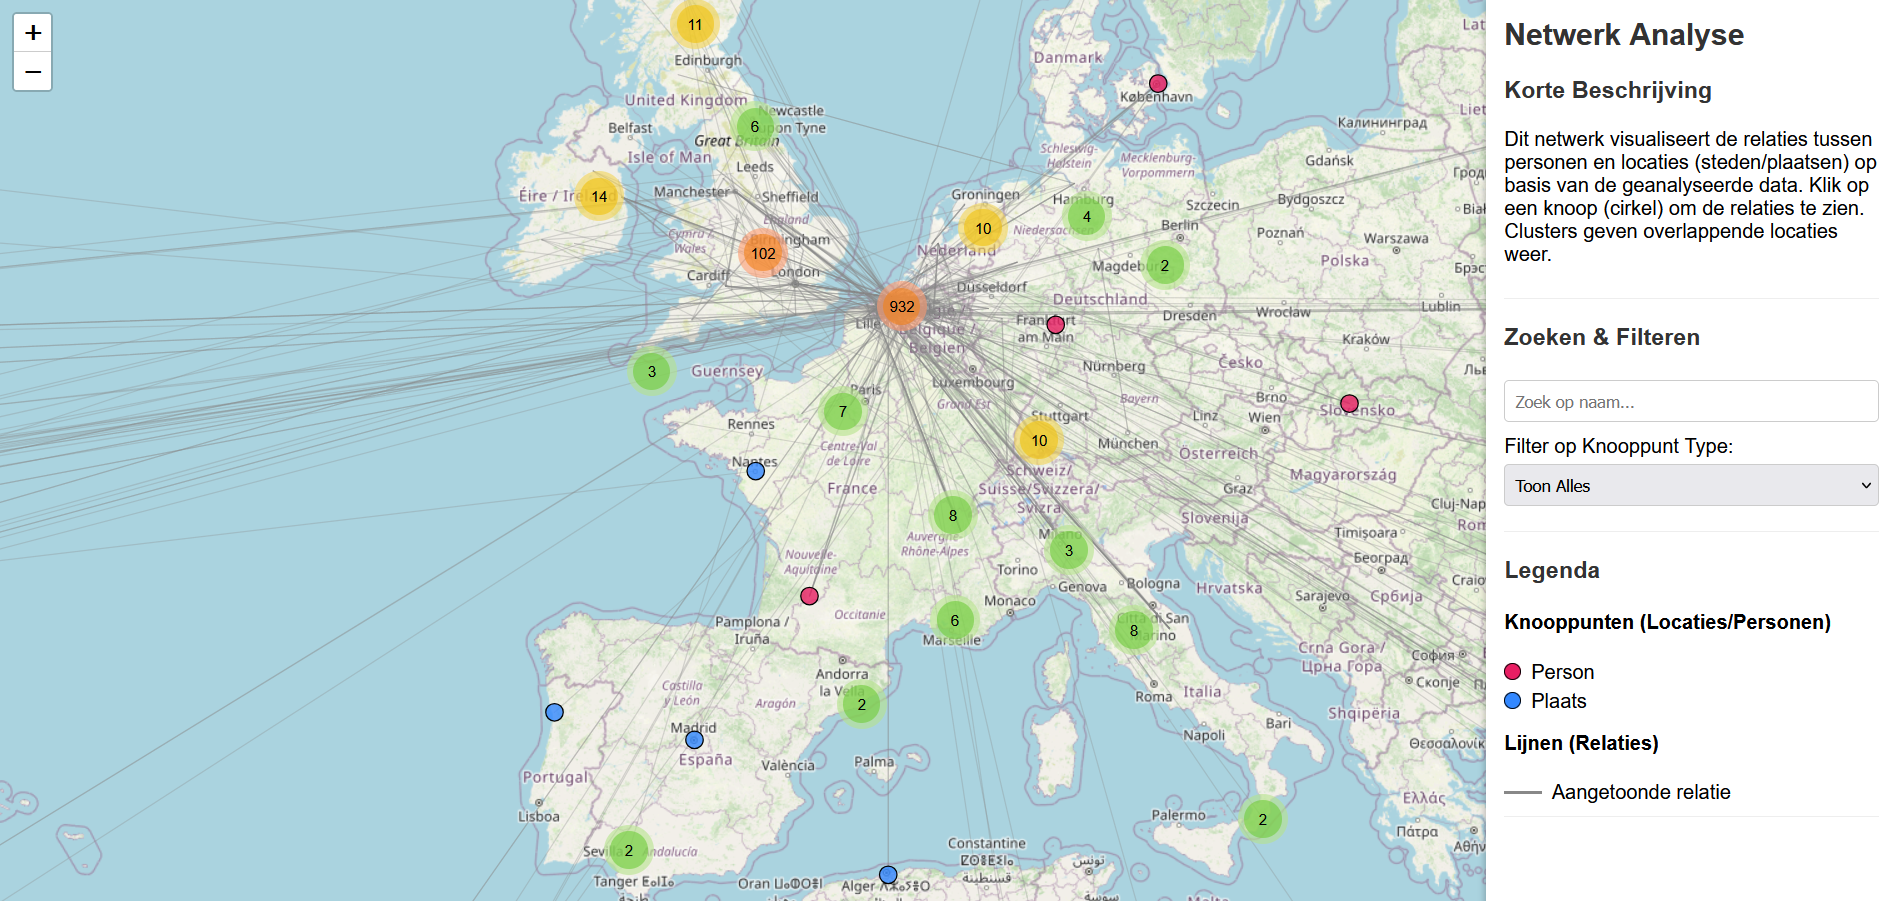

https://guacamolekoala.github.io/Visualisatie4BGuidoGezelle/